# Initialization

## Import of Libraries Needed

- import of libraries neede
- definition of global variables

In [1]:
import requests 
import json 
import os
import logging
import warnings
import pandas as pd
from dotenv import load_dotenv, find_dotenv

## Definition of Global Variables

This includes:
- magic values
- Dependency-Track base URL and API URL
- API KEY for Dependency-Track
- configuration of loggin

## Assumptions 
- The Dependency-Track API key has been added to the `.env` file with the name `DEPENDENCY_TRACK_API_KEY`.
- The notebook needs to be **connected to Roche VPN** to access Dependency-Track and Defect Dojo`

- For **WSL2** users, `wsl-vpnkit` needs to be installed and started from PowerShell using the following command:

```bash
wsl.exe -d wsl-vpnkit --cd /app wsl-vpnkit
```

In [150]:
# Set magic values
SUCCESS_STATUS_CODE = 200

# Set Dependency Track instance base URL
DEPENDENCY_TRACK_BASE_URL = "https://dependency-track.poc.roche.com"  
# Set API version
API_VERSION = "v1"  
# Set the API URL of your Dependency Track instance
DEPENDENCY_TRACK_API_URL = f"{DEPENDENCY_TRACK_BASE_URL}/api/{API_VERSION}"

# Load API_KEY
_ = load_dotenv(find_dotenv())
API_KEY  = os.getenv('DEPENDENCY_TRACK_API_KEY')

# Configure the logging
logging.basicConfig(filename='log.txt', level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Worker functions

| Name | Description |
|------|-------------|
|`get_all_projects()`|Retrieve all projects and their versions from the Dependency Track API|
|`get_project_components(project_uuid, api_key, base_url)`| Retrieve all component information from the SBOM of a specific project|

## get_all_projects

In [3]:
def get_all_projects(api_key, base_url):
    """
    Retrieve all projects and their versions from the Dependency Track API.
    
    Returns:
        pandas.DataFrame or None:
            A DataFrame containing project names, versions, and UUIDs,
            or None if the request fails.
    Raises:
        None
    
    Example:
        >>> api_key = "your_api_key"
        >>> base_url = "https://dependency-track.example.com/api/v1/"
        >>> df = get_all_projects(api_key, base_url)
        DataFrame with project information (Name, Version, UUID) or None
    
    Notes:
        The `SUCCESS_STATUS_CODE` constant represents the HTTP status code that indicates a successful
        response from the Dependency Track API. By default, it is set to 200.
    """  
    # Set the headers with the API key
    headers = {
        "accept": "application/json",
        "X-Api-Key": api_key
    }
    
    # Make the request to get all projects
    projects_endpoint = f"{base_url}/project"
    response = requests.get(
        projects_endpoint,
        headers=headers,
        verify=False
    )

    # Check the response status
    if response.status_code == SUCCESS_STATUS_CODE:
        projects = response.json()
        data = {
            "Name": [],
            "Version": [],
            "UUID": []
        }
        for project in projects:
            project_name = project["name"]
            project_uuid = project["uuid"]

            data["Name"].append(project_name)
            data["UUID"].append(project_uuid)

            # Get the versions for each project
            
            # Make the request to get versions for a project
            project_endpoint = f"{base_url}/project/{project_uuid}"
            response = requests.get(
                project_endpoint,
                headers=headers,
                verify=False
            )
            # Check the response status
            if response.status_code == SUCCESS_STATUS_CODE:
                project_info = response.json()
                if "version" in project_info :
                    data['Version'].append(project_info['version'])
                else:
                    data['Version'].append(pd.NA)      
            else:
                data['Version'].append(pd.NA)
                logging.error("Failed to get project version.")

        # Create the dataframe
        df = pd.DataFrame(data)
        return df

    else:
        logging.error("Failed to get projects.")
        return None

In [158]:
def get_project_components(project_uuid, api_key, base_url):
    """
    Retrieve all component information from the SBOM of a specific project.
    
    Args:
        project_uuid (str): The UUID of the project.
        api_key (str): The API key for authentication with the Dependency Track API.
        base_url (str): The base URL of the Dependency Track API.
    
    Returns:
        pd.DataFrame or None:
            A DataFrame containing component names, versions, and UUIDs,
            or None if the request fails.

    Raises:
        None
    
    Example:
        >>> api_key = "your_api_key"
        >>> base_url = "https://dependency-track.example.com/api/v1/"
        >>> df = get_project_SBOM_components("your_project_uuid", api_key, base_url)
        DataFrame with component information or None
    
    Notes:
        The `SUCCESS_STATUS_CODE` constant represents the HTTP status code that indicates a successful
        response from the Dependency Track API. By default, it is set to 200.
    """
    
    # Set the headers with the API key
    headers = {
        "accept": "application/vnd.cyclonedx+xml",
        "X-Api-Key": api_key
    }

    # Construct the API endpoint URL
    sbom_endpoint = f"{base_url}/bom/cyclonedx/project/{project_uuid}"

    # Make the API request to retrieve the SBOM data
    response = requests.get(sbom_endpoint, headers=headers, verify=False)

    # Check if the request was successful (HTTP status code 200)
    if response.status_code == SUCCESS_STATUS_CODE:
        sbom_data = response.json()
        
        try:
            # Process the SBOM data as 
            df = pd.DataFrame(sbom_data['components'])
        except KeyError:
            df = None
        return df
    else:
        print("Error: Failed to retrieve SBOM data.")
        return None

In [203]:
def get_project_data(project_name, scanner_names):
    """
    Retrieves and combines data frames for a given project name and list of scanner names.

    Parameters:
        project_name (str): The name of the project.
        scanner_names (list): A list of scanner names.

    Returns:
        pandas.DataFrame: The combined data frame containing the values of all projects.

    Raises:
        IndexError: If the UUID for a scanner project is not found in the projects_df.

    Example:
        combined_df = get_project_data('project_name', ['scanner1', 'scanner2'])
    """
    
    # Add list with UUID to every scanner project for the current project_name
    uuids = [projects_df.loc[projects_df['Name'] == f"{project_name}_{scanner_name}", 'UUID'].values[0]  for scanner_name in scanner_names]
 
    try:
        # Create a list of the data frames
        data_frames = [get_project_components(uuid, API_KEY, DEPENDENCY_TRACK_API_URL)  for uuid in uuids]
    except Exception as e:
        # Handle the exception here
        print("An error occurred:", str(e))
    
    # Add scanner name and UUID columns to each data frame
    for i, df in enumerate(data_frames):
        if df is not None:
            df['scanner_name'] = scanner_names[i]
            df['UUID'] = uuids[i]
        else:
            print(f"No component information available for project {project_name} with project uuid {uuids[i]}")
    
    # Concatenate the data frames into one
    combined_df = pd.concat(data_frames, ignore_index=True)

    return combined_df

In [6]:
def eval_unique_and_common(df1, df2):

    # Get the unique names from the 'name' column in df1 and df2
    unique_names_df1 = df1.unique()
    unique_names_df2 = df2.unique()

    # Find the common names between the two data frames
    common_names = set(unique_names_df1).intersection(unique_names_df2)

    # Count the number of common names and different names
    num_common_names = len(common_names)
    num_different_names_df1 = len(unique_names_df1) - num_common_names
    num_different_names_df2 = len(unique_names_df2) - num_common_names

    # Prepare the results dictionary
    result = {
        "num_different_names_df1": num_different_names_df1,
        "num_common_names": num_common_names,
        "num_different_names_df2": num_different_names_df2
    }

    return result


In [7]:
# import modules
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

def create_venn2_diagram(ax, set_names, set_values, output_file=None):
    # Validate input arguments
    if not (isinstance(set_names, tuple) and len(set_names) == 2 and isinstance(set_names[0], str) and isinstance(set_names[1], str)):
        raise ValueError("Error: The first input argument 'set_names' must be a tuple of length 2")
    if not (isinstance(set_values, tuple) and len(set_values) == 2 and isinstance(set_values[0], set) and isinstance(set_values[1], set)):
        raise ValueError("Error: The second input argument 'set_values' must be a tuple of length 2")

    # grab input sets
    A = set_values[0]
    B = set_values[1]

    # Define the intersection sizes
    A_not_B = A - B
    B_not_A = B - A
    A_and_B = A & B
    
    # Define the sizes of the datasets
    size_A_not_B = len(A_not_B)
    size_B_not_A = len(B_not_A)
    size_A_and_B = len(A_and_B)
  
    # depict venn diagram
    venn2(subsets=(size_A_not_B, size_B_not_A, size_A_and_B), 
        set_labels=set_names,
        set_colors=("blue", "orange"), alpha=0.7, ax=ax)

    # customize plot dimensions and font 
#    ax.set_title(f"Venn Diagram for {set_names[0]} and {set_names[1]}", fontsize=12)  # Set the title font size
#    ax.set_xlabel(set_names[0], fontsize=10)  # Set the x-axis label font size
#    ax.set_ylabel(set_names[1], fontsize=10)  # Set the y-axis label font size
#    ax.tick_params(labelsize=8)  # Set the tick label font size
#    ax.text(0.5, 0.95, f"Intersection Size: {size_A_and_B}", fontsize=10, ha='center')  # Set the text font size
    
    if output_file:
        # Save the plot to a file
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
 
  
    # assign title of the venn diagram
#    plt.title(f"Venn Diagram for {set_names[0]} and {set_names[1]}")  
#    plt.show()

In [8]:
# import modules
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

def create_venn3_diagram(set_names, set_values):

    # Validate input arguments
    if not (isinstance(set_names, tuple) and len(set_names) == 3 and isinstance(set_names[0], str) and isinstance(set_names[1], str)):
        raise ValueError("Error: The first input argument 'set_names' must be a tuple of length 2")
    if not (isinstance(set_values, tuple) and len(set_values) == 3 and isinstance(set_values[0], set) and isinstance(set_values[1], set)):
        raise ValueError("Error: The second input argument 'set_values' must be a tuple of length 2")

    # grab input sets
    A = set_values[0]
    B = set_values[1]
    C = set_values[2]

    # Define the intersection sizes
    A_and_B = A & B
    A_and_C = A & C
    B_and_C = B & C
    A_and_B_and_C = A & (B & C)
    A_and_B_not_ABC = A_and_B - A_and_B_and_C
    A_and_C_not_ABC = A_and_C - A_and_B_and_C
    B_and_C_not_ABC = B_and_C - A_and_B_and_C

    # Define the sizes of the datasets
    size_A = len(A)
    size_B = len(B)
    size_C = len(C)
    size_A_and_B_not_ABC = len(A_and_B_not_ABC)
    size_A_and_C_not_ABC = len(A_and_C_not_ABC)
    size_B_and_C_not_ABC = len(B_and_C_not_ABC)
    size_A_and_B_and_C = len(A_and_B_and_C)
    
    # Create the Venn diagram
    venn = venn3(subsets=(size_A, size_B, size_A_and_B_not_ABC, size_C, size_A_and_C_not_ABC, size_B_and_C_not_ABC, size_A_and_B_and_C), 
                 set_labels = set_names) 

    # Add labels to the regions
#    venn.get_label_by_id('100').set_text(set_names[0])
#    venn.get_label_by_id('010').set_text(set_names[1])
#    venn.get_label_by_id('001').set_text(set_names[2])
#    venn.get_label_by_id('110').set_text(f"{set_names[0]} and {set_names[1]}")
#    venn.get_label_by_id('101').set_text(f"{set_names[0]} and {set_names[2]}")
#    venn.get_label_by_id('011').set_text(f"{set_names[1]} and {set_names[2]}")
#    venn.get_label_by_id('111').set_text(f"{set_names[0]}, {set_names[1]} and {set_names[2]}")

    # Display the Venn diagram
    plt.title('Venn Diagram')
    plt.show()

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib_venn import venn2, venn3

def create_plot_data(set_values):

    # grab input sets
    A = set_values['A']
    B = set_values['B']
    C = set_values['C']
    D = set_values['D']
    E = set_values['E']

    # Define the intersection sizes
    A_not_B = A - B
    B_not_C = B - C
    C_not_D = C - D
    D_not_E = D - E

    B_not_A = B - A
    C_not_B = C - B
    D_not_C = D - C
    E_not_D = E - D
    
    A_and_B = A & B
    B_and_C = B & C
    C_and_D = C & D
    D_and_E = D & E
    A_and_D = A & D 
    B_and_D = B & D

    A_not_B_union_D = A - (B | D)
    B_not_A_union_D = B - (A | D)
    A_and_B_minus_D = (A & B) - D
    D_not_A_union_B = D - (A | B)
    A_and_D_minus_B = (A & D) - B
    B_and_D_minus_A = (B & D) - A
    A_and_B_and_D = (A & B) & D 
    
    # Define the sizes of the datasets
    size_A = len(A)
    size_B = len(B)
    size_C = len(C)
    size_D = len(D)
    size_E = len(E)
    
    size_A_not_B = len(A_not_B)
    size_B_not_C = len(B_not_C)
    size_C_not_D = len(C_not_D)
    size_D_not_E = len(D_not_E)

    size_B_not_A = len(B_not_A)
    size_C_not_B = len(C_not_B)
    size_D_not_C = len(D_not_C)
    size_E_not_D = len(E_not_D)

    size_A_and_B = len(A_and_B)
    size_B_and_C = len(B_and_C)
    size_C_and_D = len(C_and_D)
    size_D_and_E = len(D_and_E)
    size_B_and_D = len(B_and_D)

    set_A_not_B_union_D = len(A_not_B_union_D)
    set_B_not_A_union_D = len(B_not_A_union_D)
    set_A_and_B_minus_D = len(A_and_B_minus_D)
    set_D_not_A_union_B = len(D_not_A_union_B)
    set_A_and_D_minus_B = len(A_and_D_minus_B)
    set_B_and_D_minus_A = len(B_and_D_minus_A)
    set_A_and_B_and_D = len(A_and_B_and_D)

    dic_values = {
        'AB':  (size_A_not_B, size_B_not_A, size_A_and_B),
        'BC':  (size_B_not_C, size_C_not_B, size_B_and_C),
        'CD':  (size_C_not_D, size_D_not_C, size_C_and_D),
        'DE':  (size_D_not_E, size_E_not_D, size_D_and_E),
        'ABD': (set_A_not_B_union_D, set_B_not_A_union_D, set_A_and_B_minus_D,
                set_D_not_A_union_B, set_A_and_D_minus_B, set_B_and_D_minus_A,
                set_A_and_B_and_D), 
    }

    return dic_values 

def visualize_set_similarities(plot_title, set_names, set_values, set_legends, output_file=None):

    # Create the figure and subplots
    fig, axs = plt.subplots(3, 2, figsize=(10, 12))

    # Set a title for the entire subplot grid
    fig.suptitle(plot_title, fontsize=12)

    # Adjust the spacing between the title and subplots
    plt.subplots_adjust(top=0.9)

    # Evaluate the values for the venn2 and venn3 plots and return them in a dictionary
    dic_values = create_plot_data(set_values)  

    # Create Venn diagrams and add to subplots

    # venn 2 diagrams
    venn_AB = venn2(subsets=dic_values['AB'], set_labels=set_names['AB'], ax=axs[1, 0], alpha=0.5)
    venn_BC = venn2(subsets=dic_values['BC'], set_labels=set_names['BC'], ax=axs[1, 1], alpha=0.5)
    venn_CD = venn2(subsets=dic_values['CD'], set_labels=set_names['CD'], ax=axs[2, 0], alpha=0.5)
    venn_DE = venn2(subsets=dic_values['DE'], set_labels=set_names['DE'], ax=axs[2, 1], alpha=0.5)

    # Customize colors if desired
    patch_10 = venn_AB.get_patch_by_id('10')
    if patch_10 is not None:
        patch_10.set_color('blue')

    patch_01 = venn_AB.get_patch_by_id('01')
    if patch_01 is not None:
        patch_01.set_color('orange')
    
    patch_10 = venn_BC.get_patch_by_id('10')
    if patch_10 is not None:
        patch_10.set_color('orange')

    patch_01 = venn_BC.get_patch_by_id('01')
    if patch_01 is not None:
        patch_01.set_color('green')
        patch_01.set_hatch('////') 

    patch_10 = venn_CD.get_patch_by_id('10')
    if patch_10 is not None:
        patch_10.set_color('green')

    patch_01 = venn_CD.get_patch_by_id('01')
    if patch_01 is not None:
        patch_01.set_color('purple')

    patch_10 = venn_DE.get_patch_by_id('10')
    if patch_10 is not None:
        patch_10.set_color('purple')

    patch_01 = venn_DE.get_patch_by_id('01')
    if patch_01 is not None:
        patch_01.set_color('gray')
        patch_01.set_hatch('////') 

    # venn 3 diagram
    venn_ABD = venn3(subsets=dic_values['ABD'], set_labels=set_names['ABD'], ax=axs[0, 0],alpha=0.5) 
    
    # Customize colors if desired
    patch_100 = venn_ABD.get_patch_by_id('100')
    if patch_100 is not None:
        patch_100.set_color('blue')

    patch_010 = venn_ABD.get_patch_by_id('010')
    if patch_010 is not None:
        patch_010.set_color('orange')

    patch_001 = venn_ABD.get_patch_by_id('001')
    if patch_001 is not None:
        patch_001.set_color('purple')
    
    # Set titles for subplots
    axs[0, 0].set_title('A vs. B vs. D')
    axs[1, 0].set_title('A vs. B')
    axs[1, 1].set_title('B vs. C')
    axs[2, 0].set_title('C vs. D')
    axs[2, 1].set_title('D vs. E')

    # Create the legend in subplot 0,1
    legend_elements = [
        Patch(facecolor='blue', edgecolor='white', label=set_legends['A']),
        Patch(facecolor='orange', edgecolor='white', label=set_legends['B']),
        Patch(facecolor='green', edgecolor='white', linewidth=1, hatch='////', label=set_legends['C']),
        Patch(facecolor='purple', edgecolor='white', label=set_legends['D']),
        Patch(facecolor='gray', edgecolor='white', linewidth=1, hatch='////', label=set_legends['E']),
    ]
    axs[0, 1].legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=False)

    # Hide the legend subplot axes
    axs[0, 1].axis('off')

    # Adjust layout
    plt.tight_layout()

    if output_file:
        # Save the plot to a file
        plt.savefig(output_file, dpi=300, bbox_inches='tight')

    # Show the plots
    plt.show()

def create_SBOM_similarity_plot(project_name, target_fields, scanner_data, output_file=None):
    # create plot title
    plot_title = f"SBOM similarity plot for project {project_name} with target field(s): {target_fields}"
    
    # define abbreviations for scanners
    scanner_labels = {
        'A': 'A',     # Gitlab
        'B': 'B',     # JA: JFrog Advanced Security
        'C': 'C',     # JX: Jfrog Xray
        'D': 'D',     # S: Syft
        'E': 'E'      # T: Trivy
    }

    # set scanner names (abbreviations)
    set_names = {
        'AB': (scanner_labels['A'], scanner_labels['B']),
        'BC': (scanner_labels['B'], scanner_labels['C']),
        'CD': (scanner_labels['C'], scanner_labels['D']),
        'DE': (scanner_labels['D'], scanner_labels['E']),
        'ABD':(scanner_labels['A'], scanner_labels['B'], scanner_labels['D'])
    }

    set_values = {
        'A': set(scanner_data['gitlab_cont'][target_field]),
        'B': set(scanner_data['jfrog_advanced_security_cont'][target_field]),
        'C': set(scanner_data['jfrog_cont'][target_field]),
        'D': set(scanner_data['syft_cont'][target_field]),
        'E': set(scanner_data['trivy_cont'][target_field])
    }

    set_legends = {
        'A': 'A: Gitlab',
        'B': 'B: JFrog Advanced Security',
        'C': 'C: JFrog Xray',
        'D': 'D: Syft',
        'E': 'E: Trivy'
    }

    visualize_set_similarities(plot_title, set_names, set_values, set_legends, output_file)

In [184]:
def collect_all_scanner_data_of_project(project_name):

    # Add list with all scanner names
    scanner_names = ['gitlab_cont', 'jfrog_advanced_security_cont', 'jfrog_cont', 'syft_cont', 'trivy_cont']

    try:
        # get data of all scanners in 'scanner_names' for project 'project_name'
        project_data_df = get_project_data(project_name, scanner_names)
    except Exception as e:
        # Handle the exception here
        print("An error occurred:", str(e))

    # Create list with scanner index. 
    # Usage: df.loc[ind_scanner[0], [...]] to grab information from the scanner with name scanner_names[0]
    # e.g. df.loc[ind_scanner[0], ['scanner_name', 'name', 'version', 'purl']] to get 'scanner_name', 'name', 'version' and 'purl' from "gitlab_cont" scanner
    scanner_masks = [project_data_df['scanner_name'] == scanner_name for scanner_name in scanner_names]

    # Create a data frame 'data_df' with all scanner data for one project 
    data_df = {name: project_data_df.loc[mask, ['scanner_name', 'name', 'version', 'purl', 'bom-ref', 'hashes']] for name, mask in zip(scanner_names, scanner_masks)}

    # Select data from scanners and add dot df_list (df_list[0] are all data of interest from scanner scanner_names[0]

    scanner_data = {}
    for scanner_name in scanner_names:
        # Select data and reset index
        df = data_df[scanner_name]
        df.reset_index(drop=True, inplace=True)

        # Apply the parse_url function to each element of the 'purl' column
        df_parsed = df['purl'].apply(parse_purl)

        # Convert the parsed_data Series of dictionaries into a DataFrame
        df_parsed_df = pd.DataFrame(df_parsed.to_list())

        # Concatenate the parsed_df DataFrame with the original df DataFrame
        df = pd.concat([df, df_parsed_df], axis=1)

        # Add data frame for scanner_name to dictionary
        scanner_data[scanner_name] = df

    return scanner_data

In [10]:
from packageurl import PackageURL
import warnings

def parse_purl(purl_string):

    try:
        purl = PackageURL.from_string(purl_string)
        purl_components = purl.to_dict()
    except Exception as e:
    # Handle any exceptions that occurred during parsing
        warnings.warn(f"Error parsing PURL: {e}")
        purl_components = {
            'type': None,
            'namespace': None,
            'name': None,
            'version': None,
            'qualifiers': None,
            'subpath': None
        }  

    purl_components = {f'p_{key}': value for key, value in purl_components.items()}

    return purl_components 

In [217]:
list(projects_df['Name'])

['Floodlight_gitlab_cont',
 'Floodlight_jfrog_advanced_security_cont',
 'Floodlight_jfrog_cont',
 'Floodlight_syft_cont',
 'Floodlight_trivy_cont',
 'Generator_2_gitlab_cont',
 'Generator_2_jfrog_advanced_security_cont',
 'Generator_2_jfrog_cont',
 'Generator_2_syft_cont',
 'Generator_2_trivy_cont',
 'iEdgeMicroService_gitlab_cont',
 'iEdgeMicroService_jfrog_advanced_security_cont',
 'iEdgeMicroService_jfrog_cont',
 'iEdgeMicroService_syft_cont',
 'iEdgeMicroService_trivy_cont',
 'Juice_Shop_gitlab_cont',
 'Juice_Shop_jfrog_advanced_security_cont',
 'Juice_Shop_jfrog_cont',
 'Juice_Shop_syft_cont',
 'Juice_Shop_trivy_cont',
 'NMP_gitlab_cont',
 'NMP_jfrog_advanced_security_cont',
 'NMP_jfrog_cont',
 'NMP_syft_cont',
 'NMP_trivy_cont',
 'pm-dashboard-frontend_gitlab_cont',
 'pm-dashboard-frontend_jfrog_advanced_security_cont',
 'pm-dashboard-frontend_jfrog_cont',
 'pm-dashboard-frontend_syft_cont',
 'pm-dashboard-frontend_trivy_cont',
 'pm-lst-kpi-module_gitlab_cont',
 'pm-lst-kpi-modul

# Load SBOM Data

## Load Project Info

- load projects
- remove projects that are not in scope (list `out_of_scope`)
- save project info in csv file for later use in file `project_data.csv`

In [237]:
# Get all projects in dependency-track with version number and UUID
warnings.filterwarnings('ignore') # deactivate warning from SSL certificates
projects_df = get_all_projects(API_KEY, DEPENDENCY_TRACK_API_URL)

# List of projects in scope
in_scope = ['Floodlight',
            'Generator_2',
            'iEdgeMicroService',
            'Juice_Shop',
            'NMP',
            'pm-dashboard-frontend',
            'pm-lst-kpi-module',
            'pm-mongo',
            'RDCS_RDCP-Client',
            'RT-Cosmo',
            'vul_flask_app',
            'WebGoat'
           ]

# List of projects to be removed
out_of_scope = ['DD Integration',
                'Greg-Aggregated-SBOM',
                'io-isovalent-cilium',
                'Navify_Edge_gitlab_cont',
                'Navify_Edge_jfrog_advanced_security_cont',
                'Navify_Edge_jfrog_cont',
                'Navify_Edge_syft_cont',
                'Navify_Edge_trivy_cont',
                'SBOM_management_Gregs_SBOM',
                'Test DD-DT Integration 2',
                'Test-DevSecOps-syft-cont',
                'Test-DevSecOps-trivy-cont',
                'Test Integration GK',
                'Test Project',
                'vul_flask_app-mend_app',
                'vul_flask_app-snyk_app',
                'x-test']

# Remove projects that are out of scope
filtered_df = projects_df[~projects_df['Name'].isin(out_of_scope)]
# Assign the filtered DataFrame back to `projects_df` if you want to update it in-place
projects_df = filtered_df

# Save the DataFrame as a CSV file
csv_filename = 'project_info.csv'
projects_df.to_csv(csv_filename, index=False)

# Load SBOM Data
# projects_df = pd.read_csv('project_data.csv')

## Analyze SBOM Data for using different data fields

- Load data
- Analyze names
- Analyze versions
- Analyze other data fields

**Preconditions**
- Libraries imported
- Global variables defined
- projects_df available (execute `projects_df = pd.read_csv('project_data.csv')` if needed)

The following data fields are evaluated: <br>
-  `name` 
-  `p_name` 
-  `name` + `version`
-  `p_name` + `p_version`
-  hybrid `name`|`p_name` + `version`|`p_version`

### SBOM comparison based on 'name' field

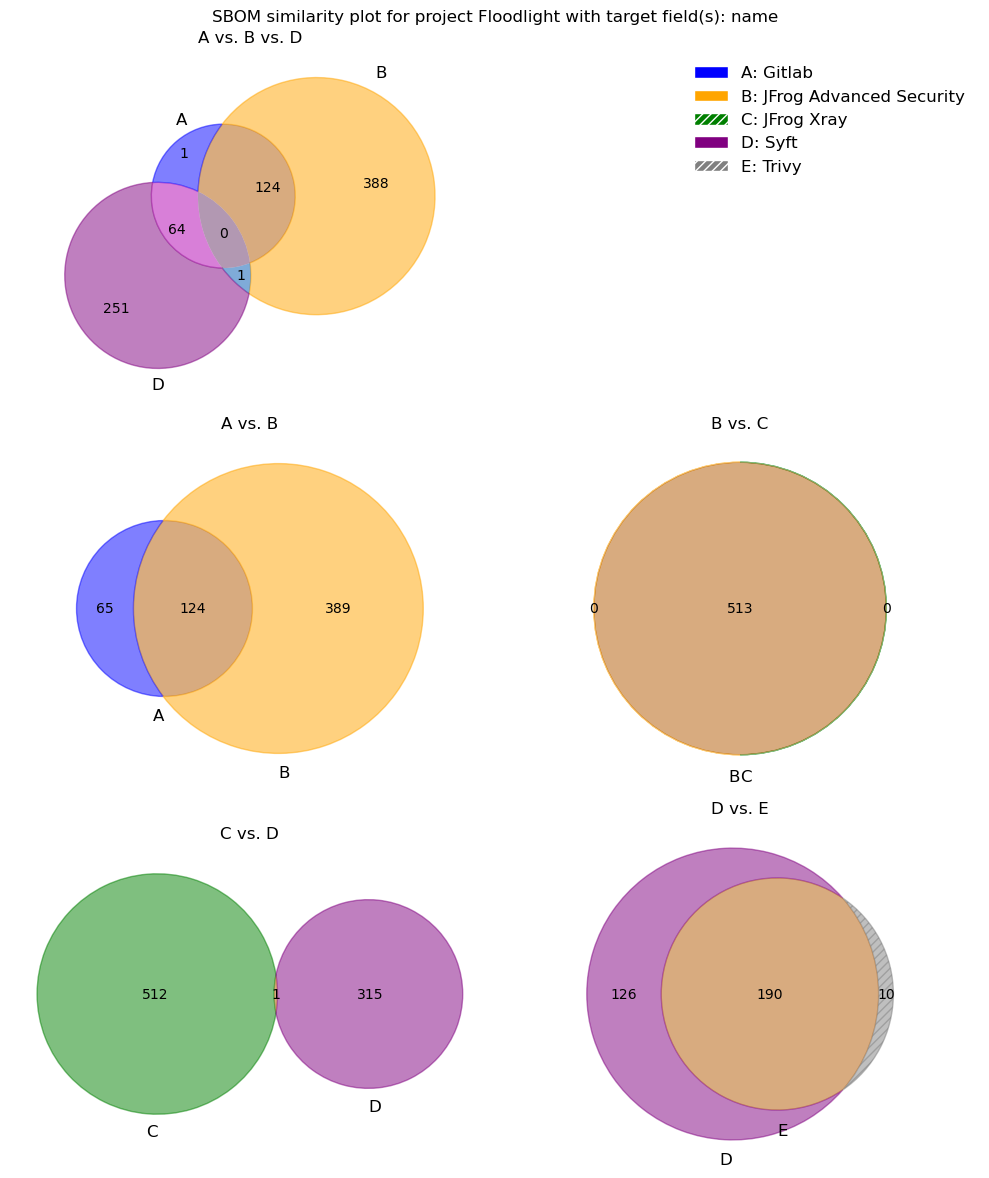

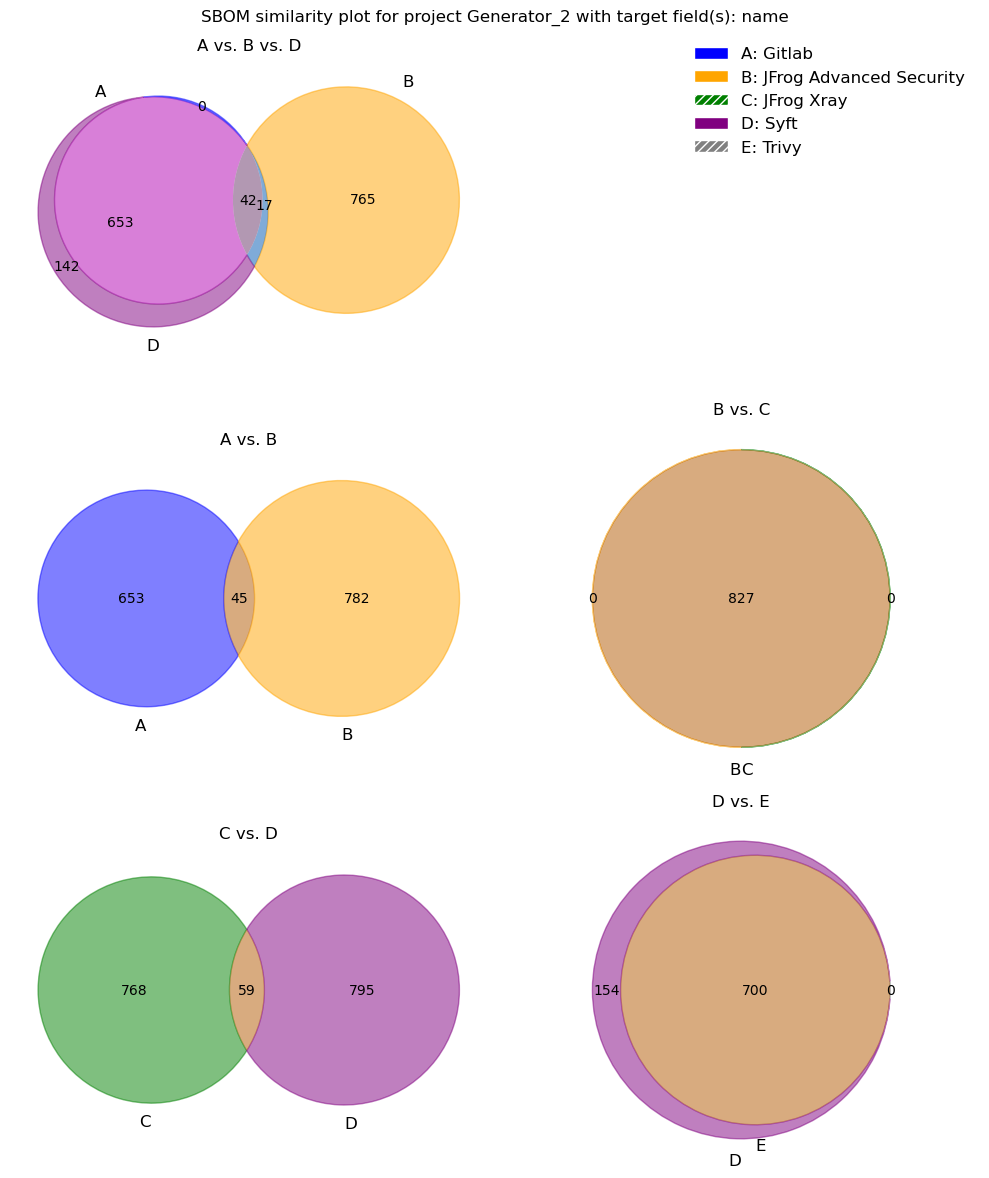

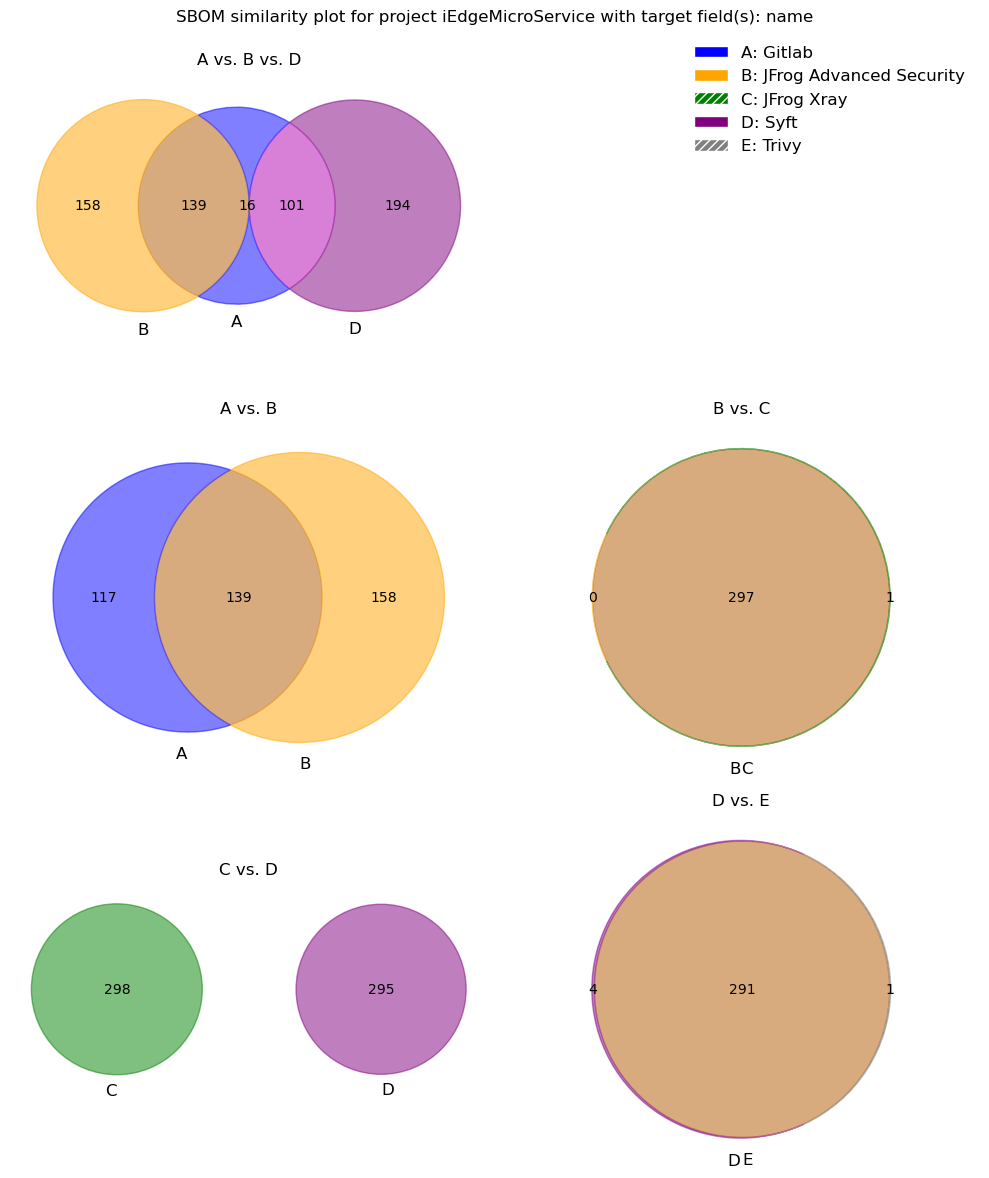

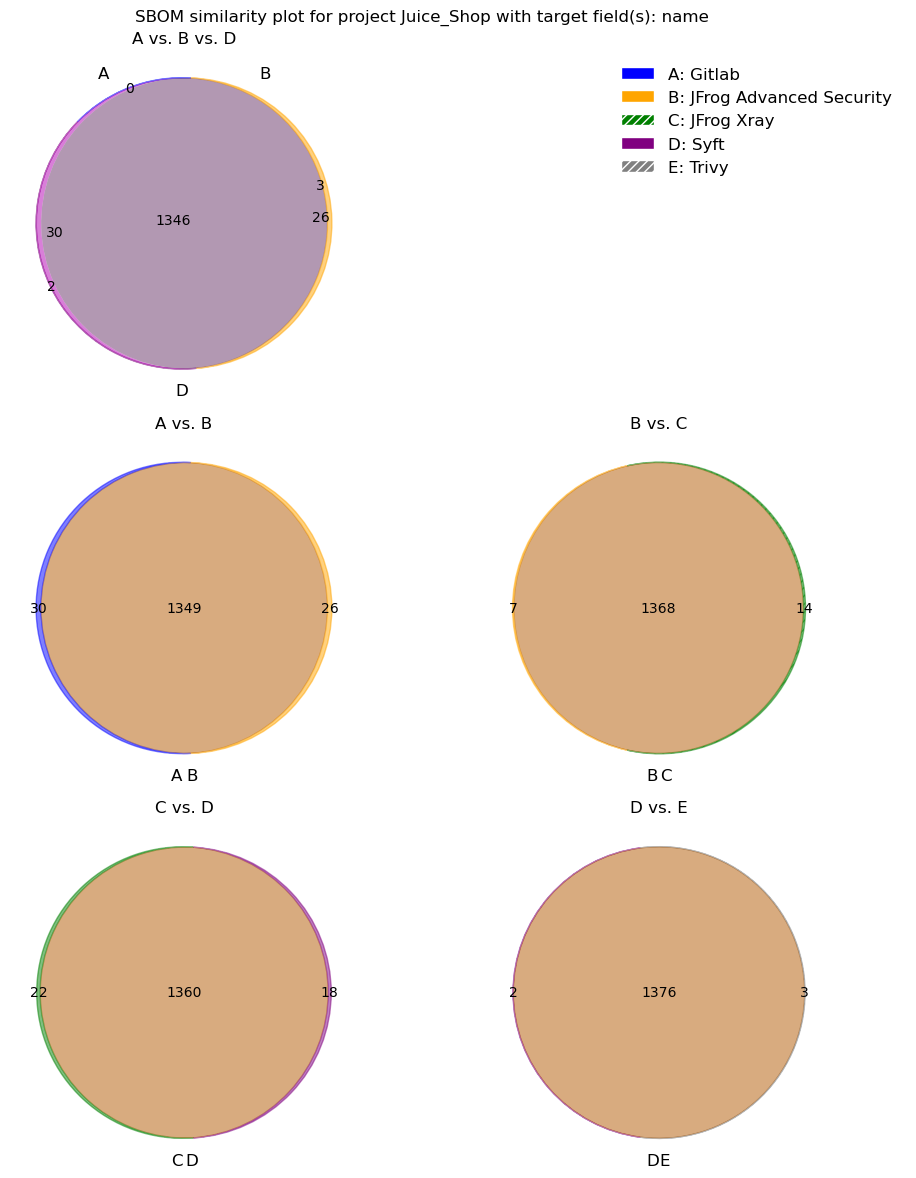

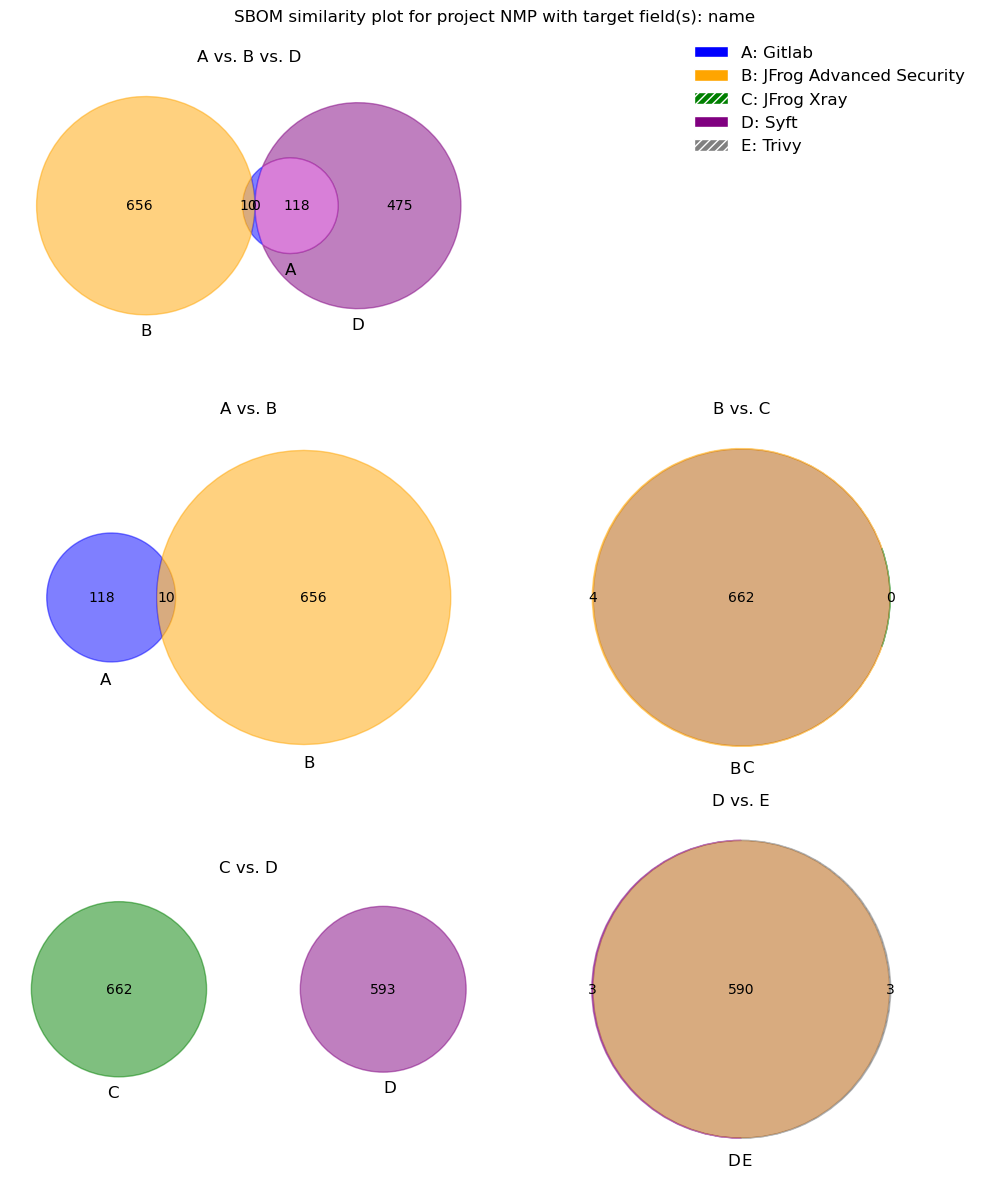

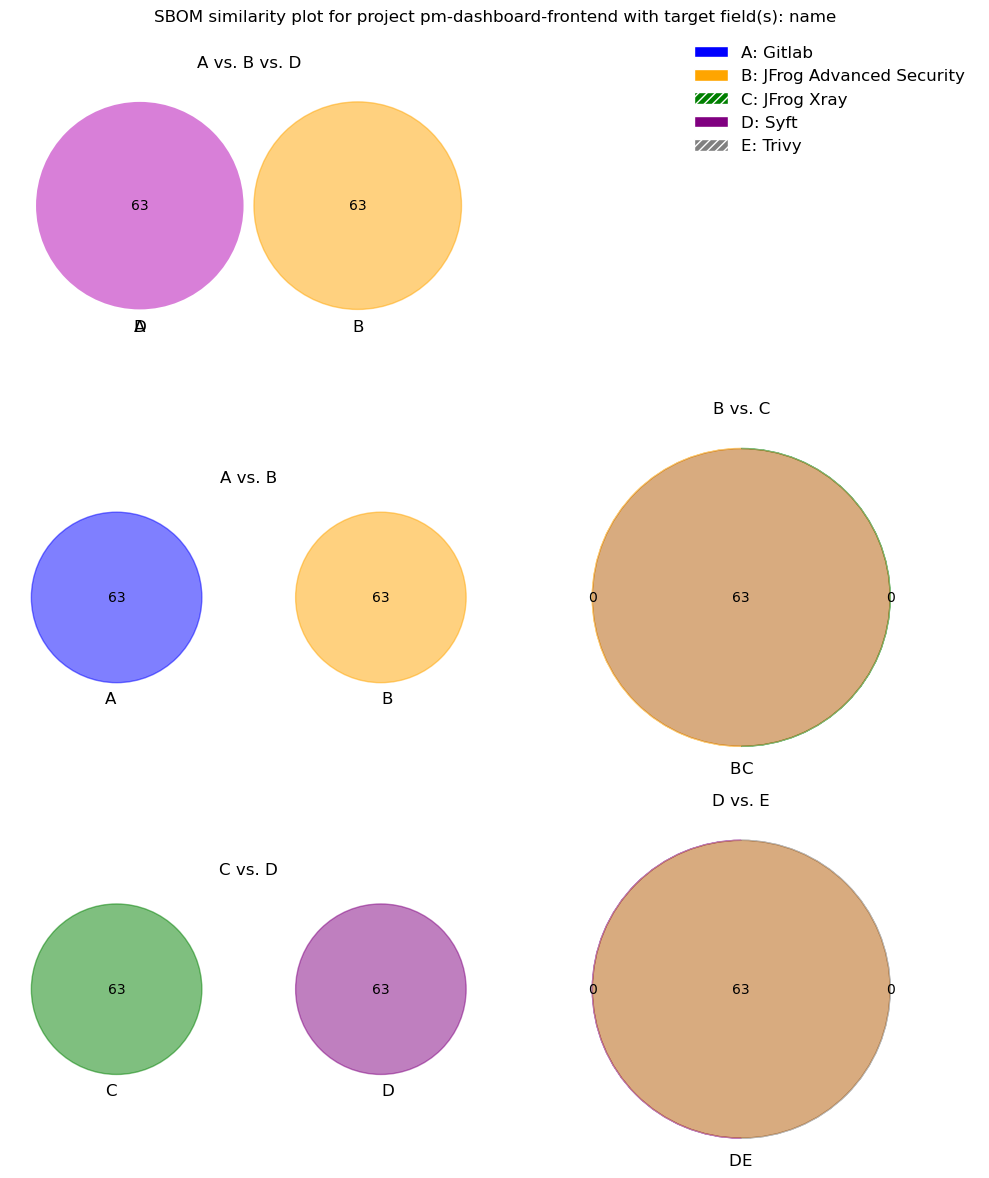

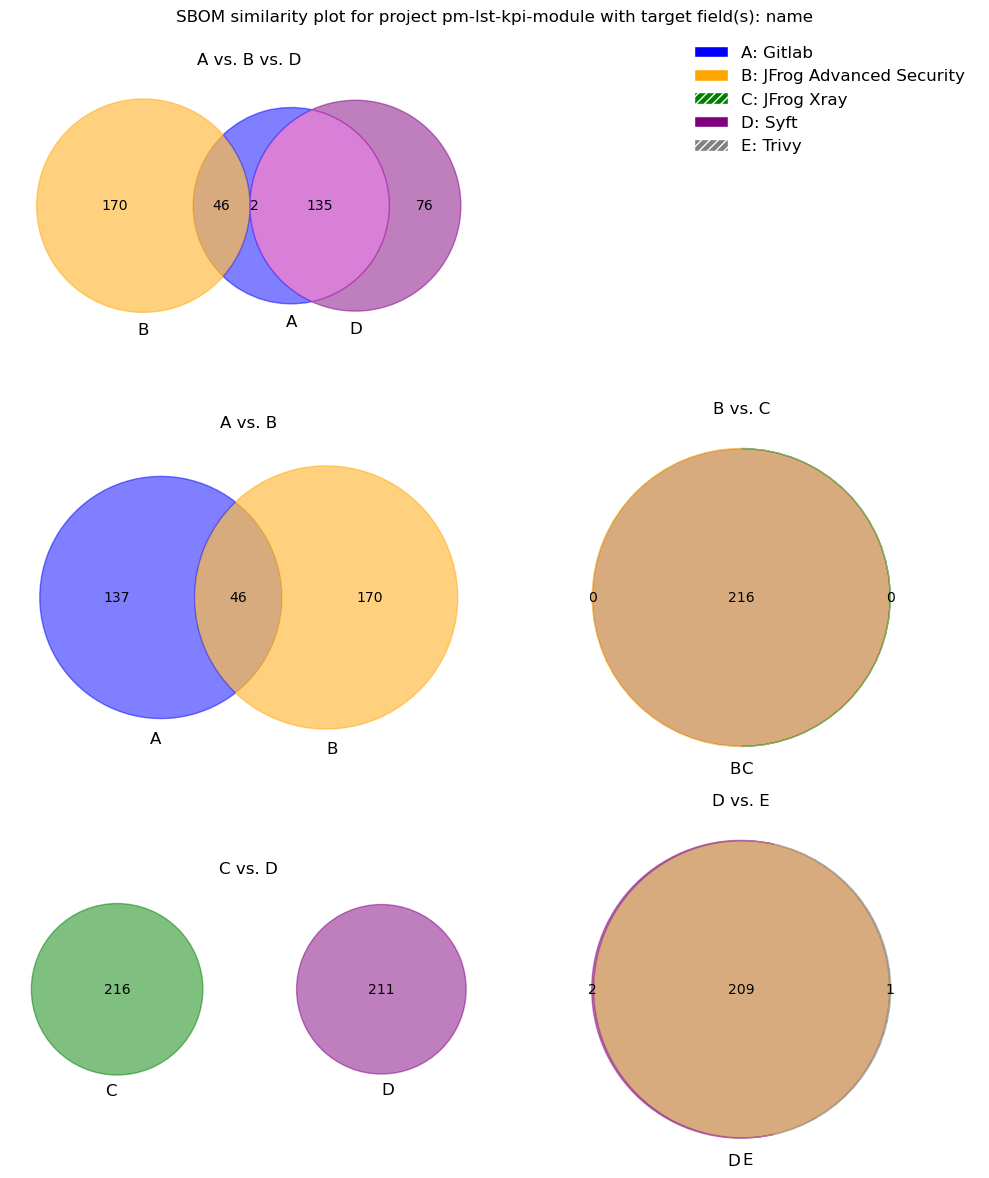

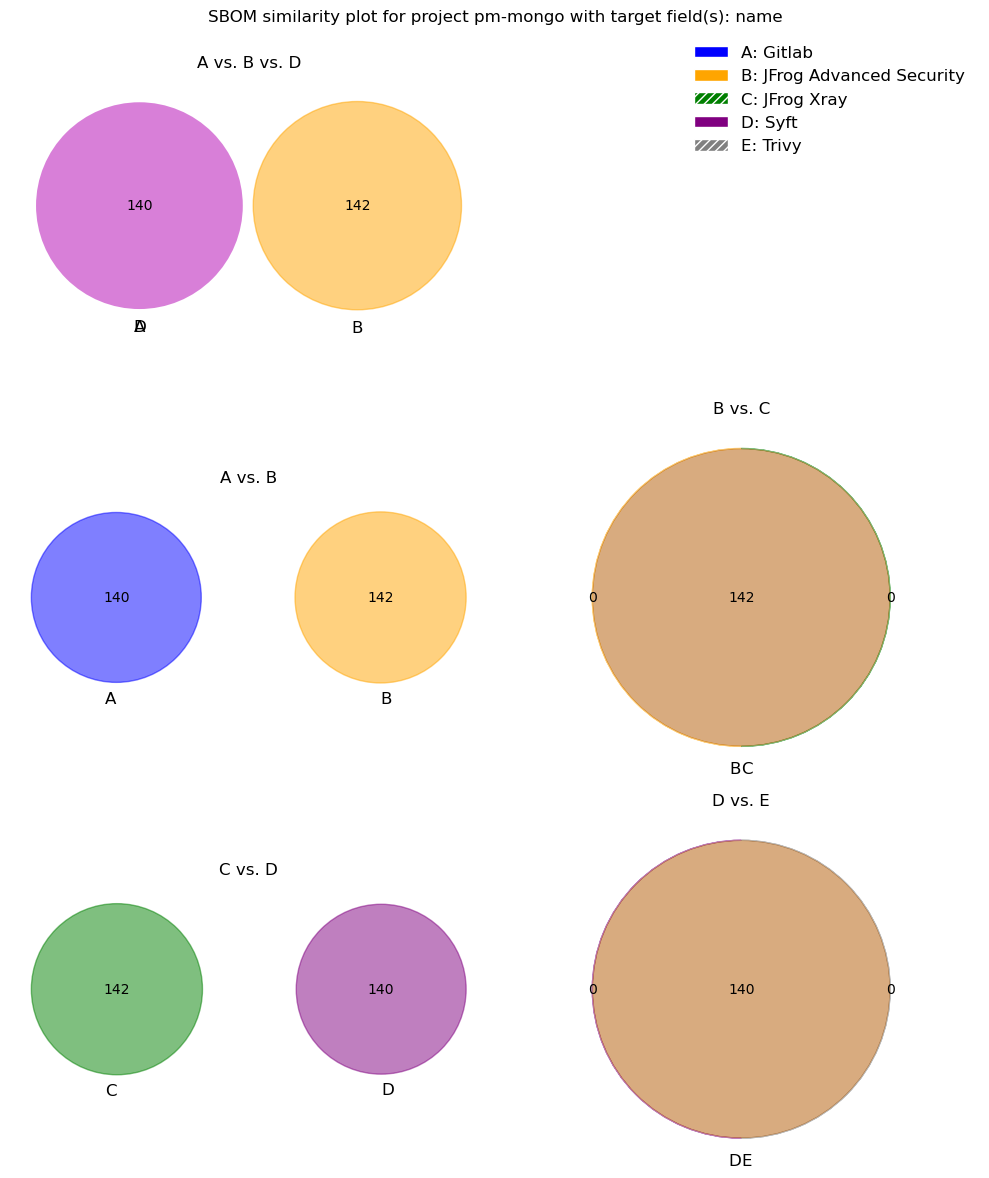

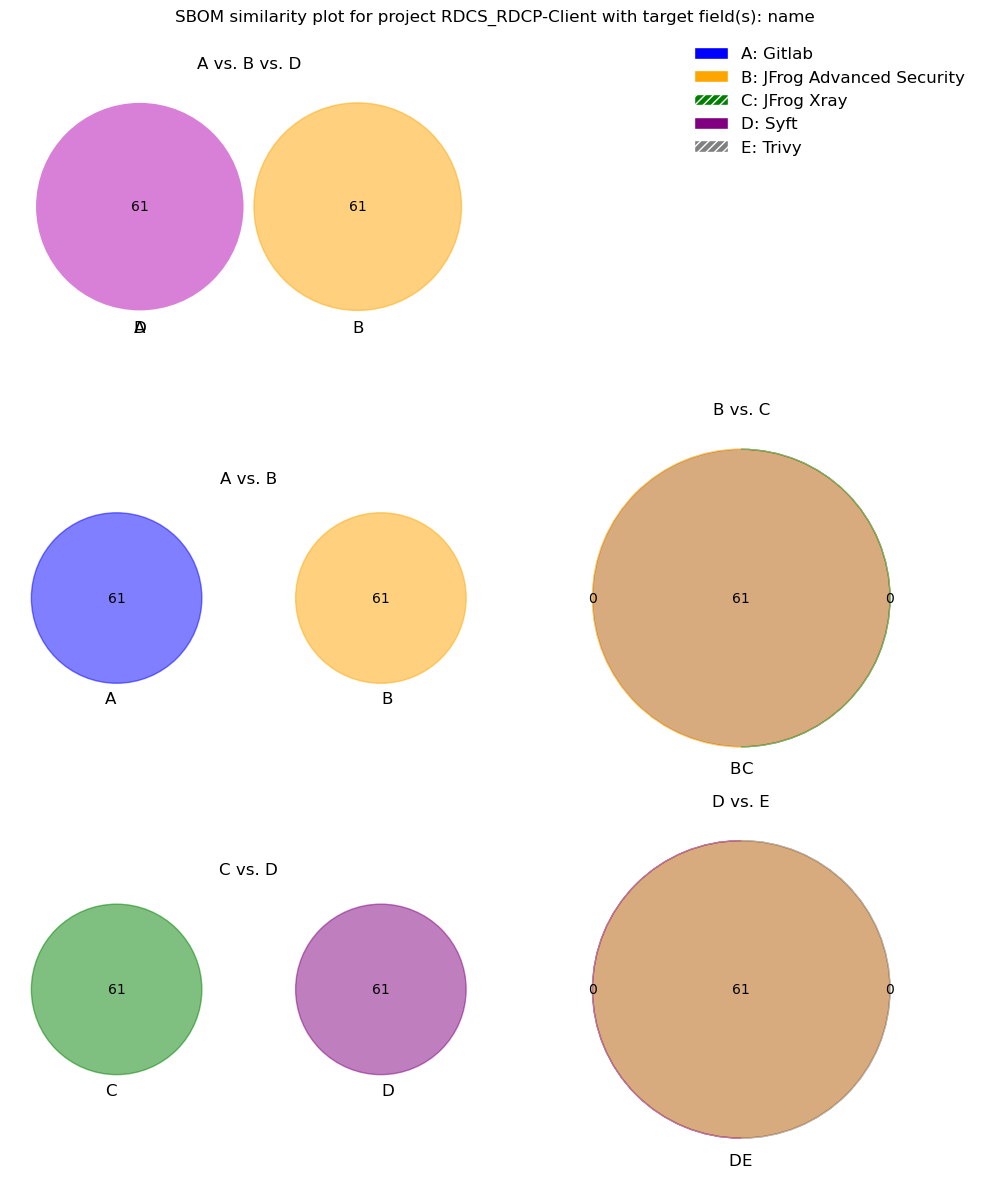

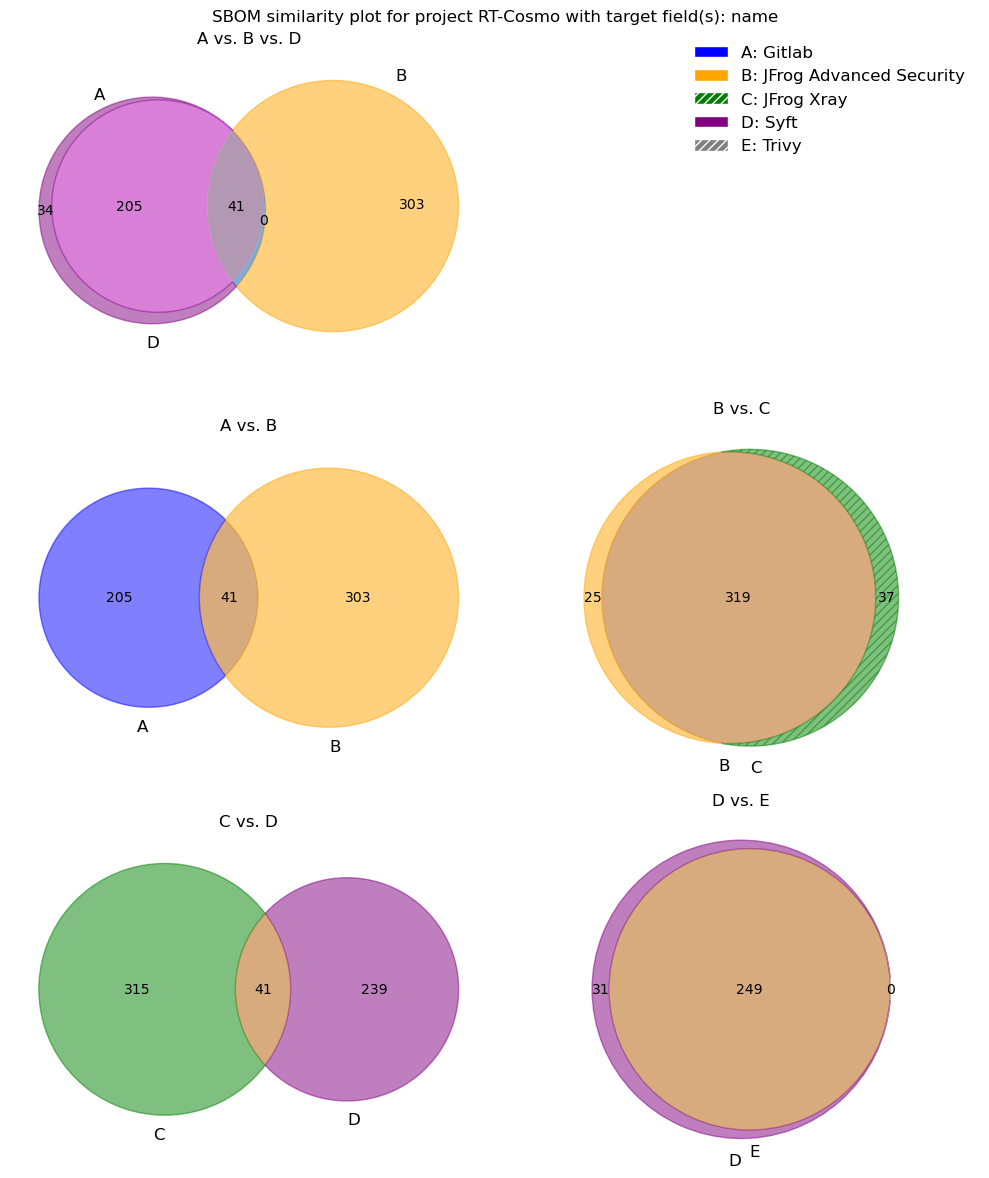

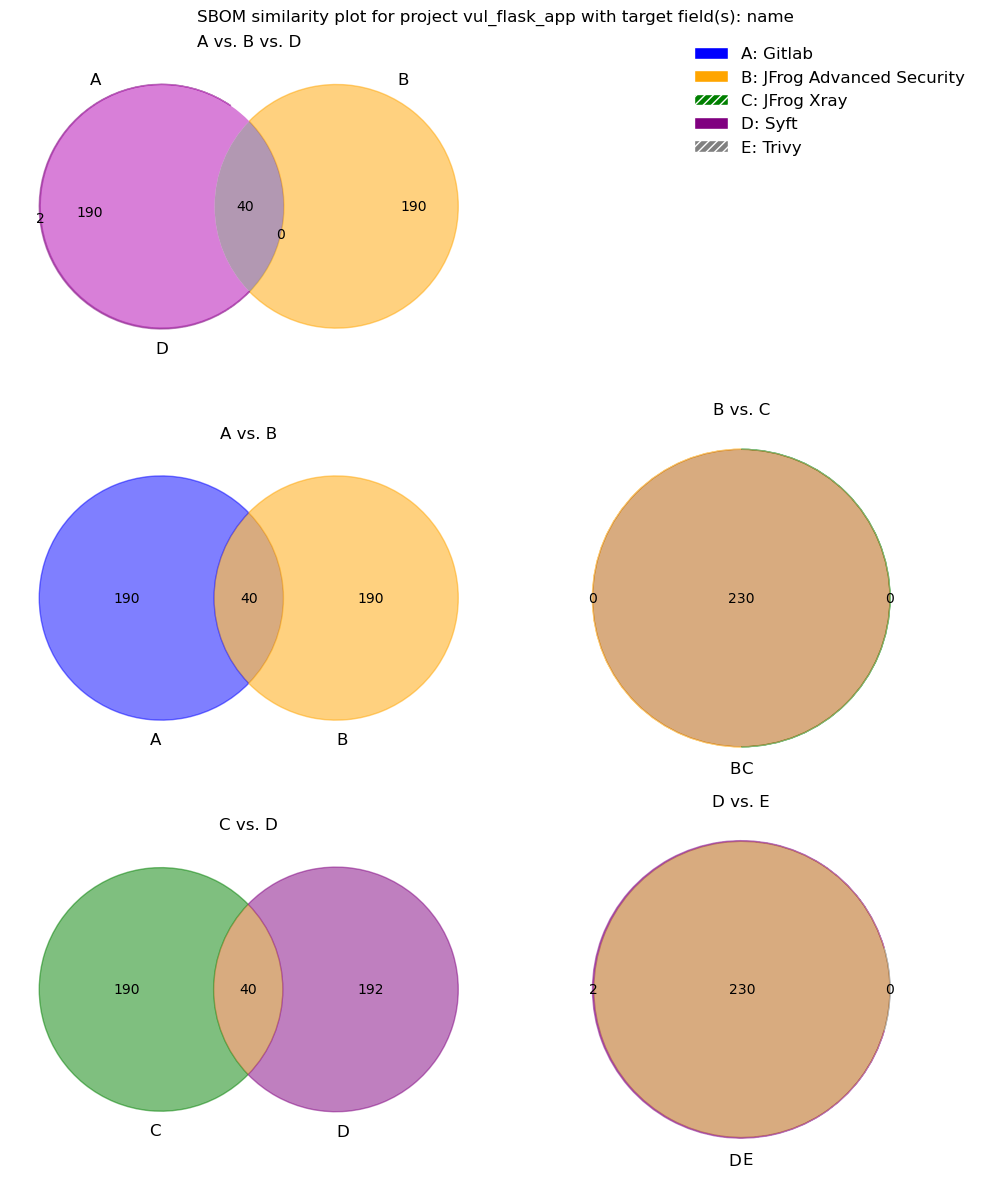

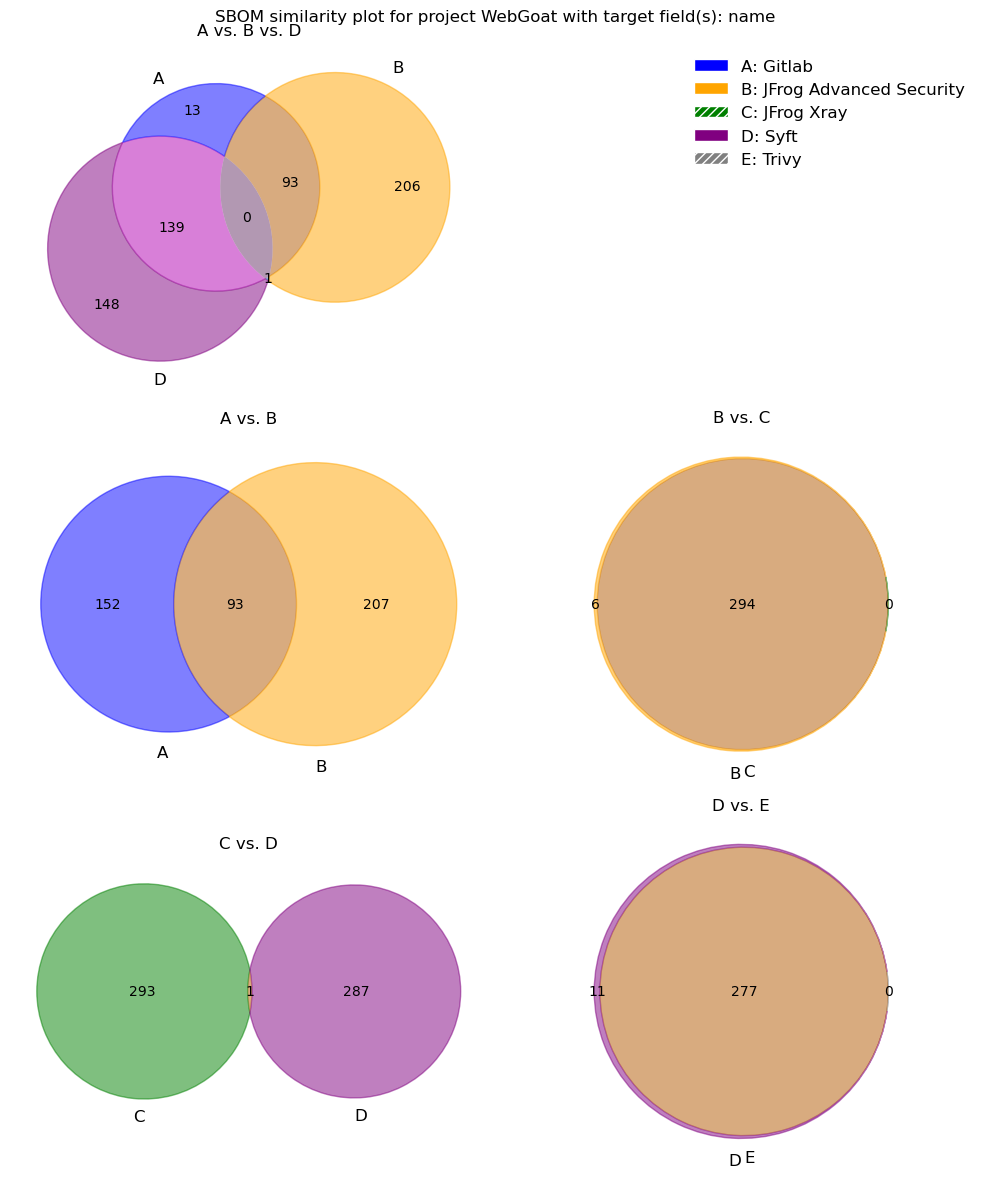

In [238]:
# define project name and target field 
project_name = in_scope[0]
target_fields = 'name'

for project_name in in_scope:
    # get project data in data frame
    project_scanner_data = collect_all_scanner_data_of_project(project_name)

    # visualize project scanner data
    target_output_file = f"SBOM_comparison_{project_name}_{target_fields}"
    create_SBOM_similarity_plot(project_name, target_fields, project_scanner_data, target_output_file)

#### Debug SBOM comparison analysis

### SBOM comparison based on 'p_name' field

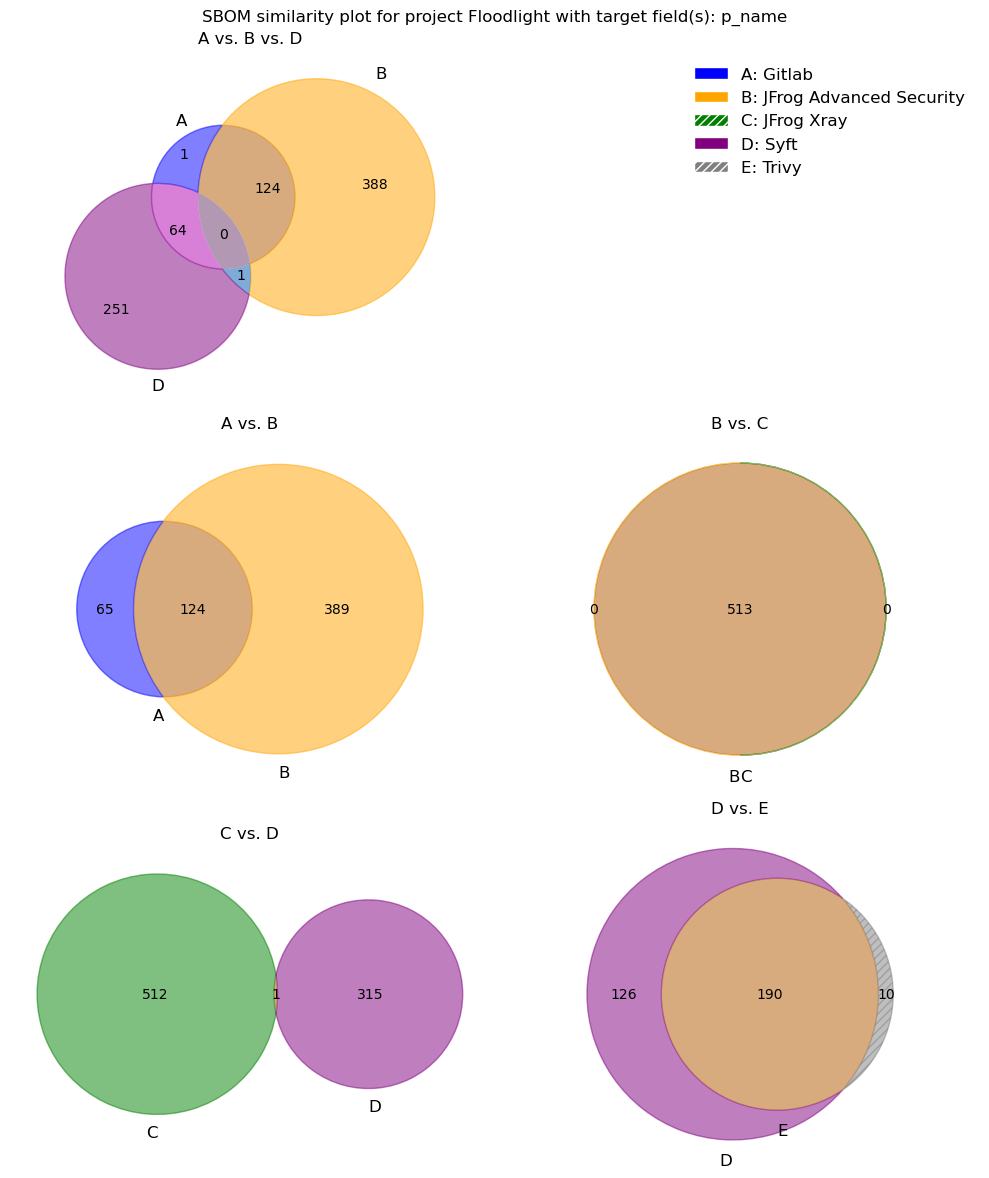

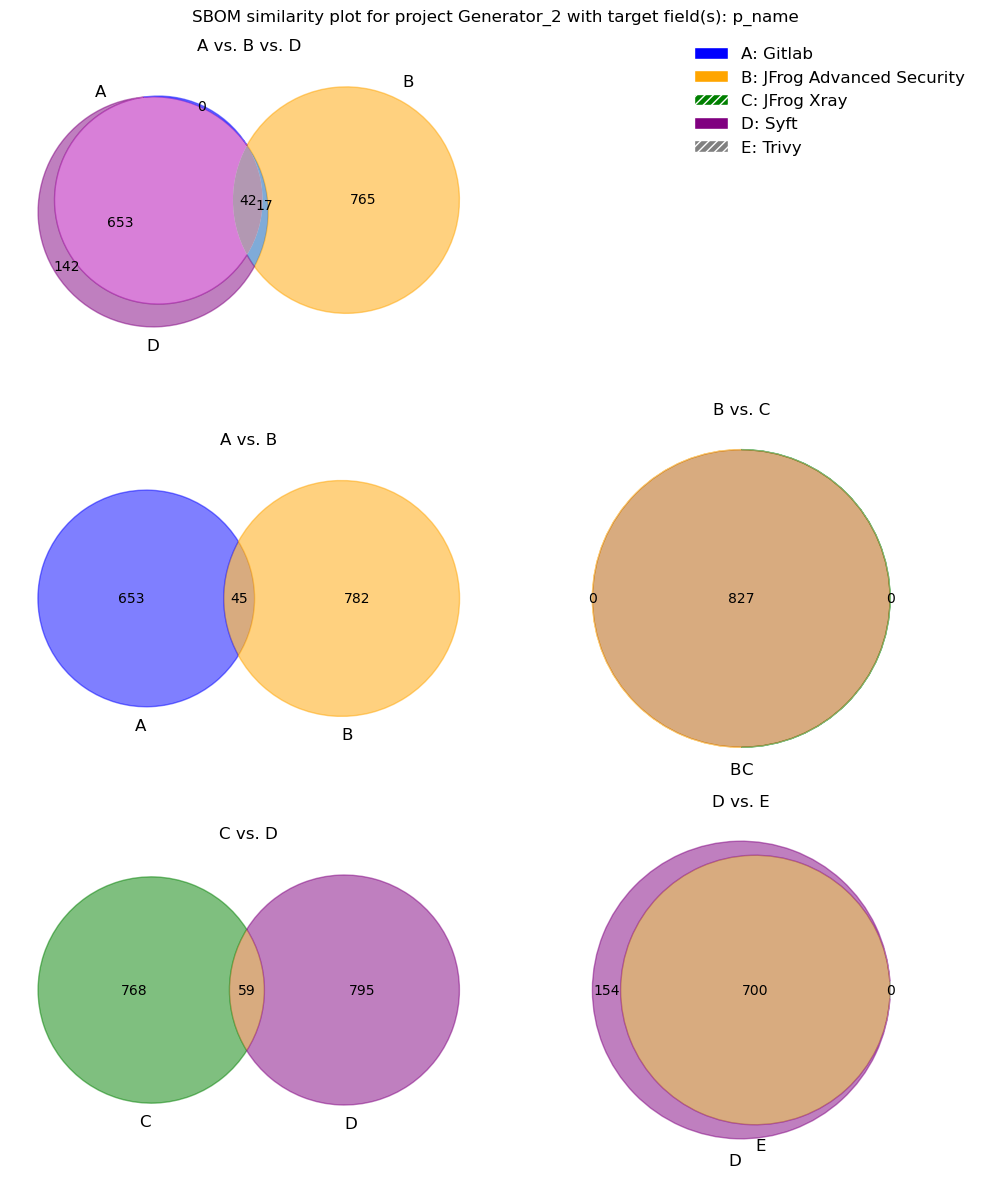

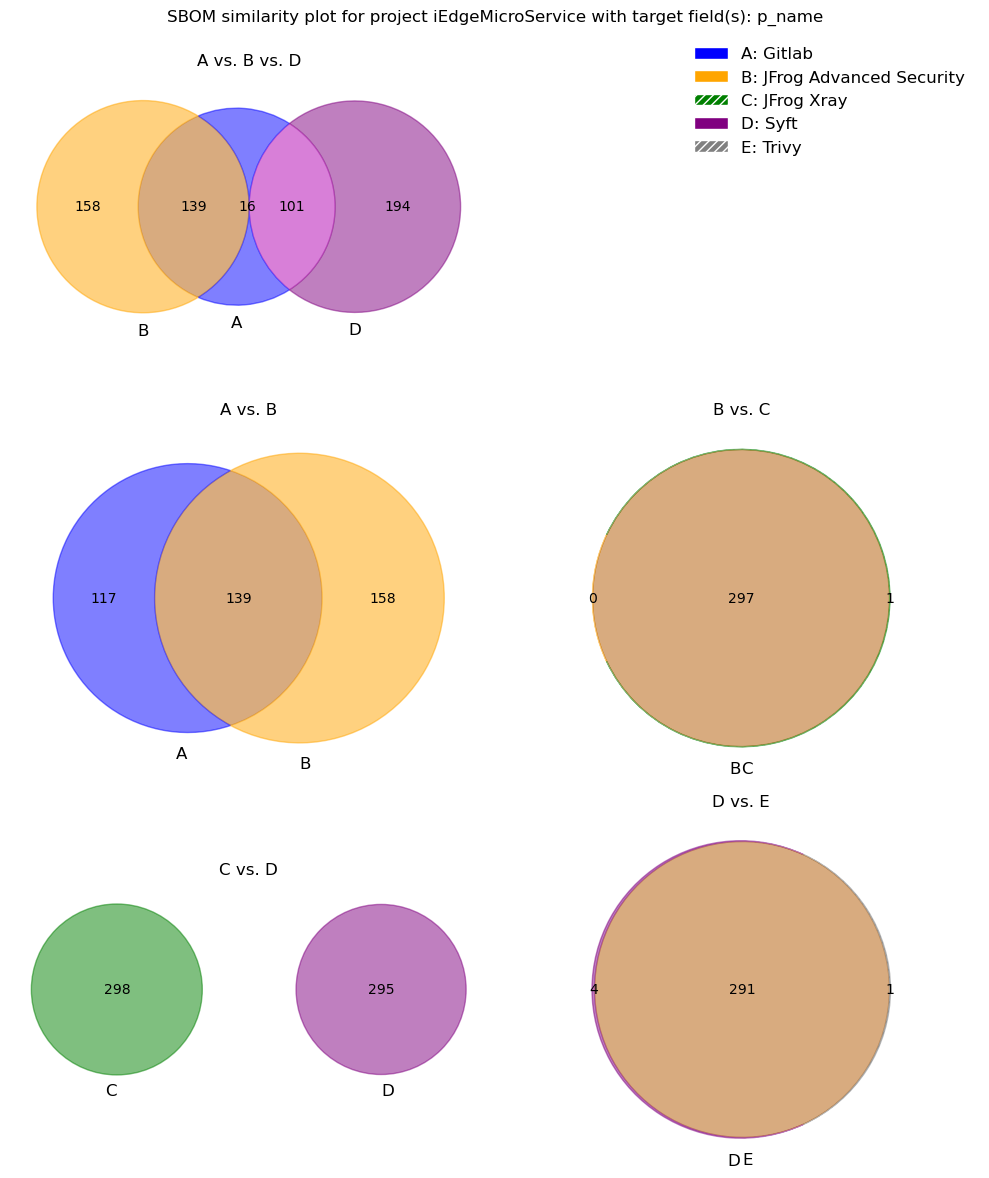

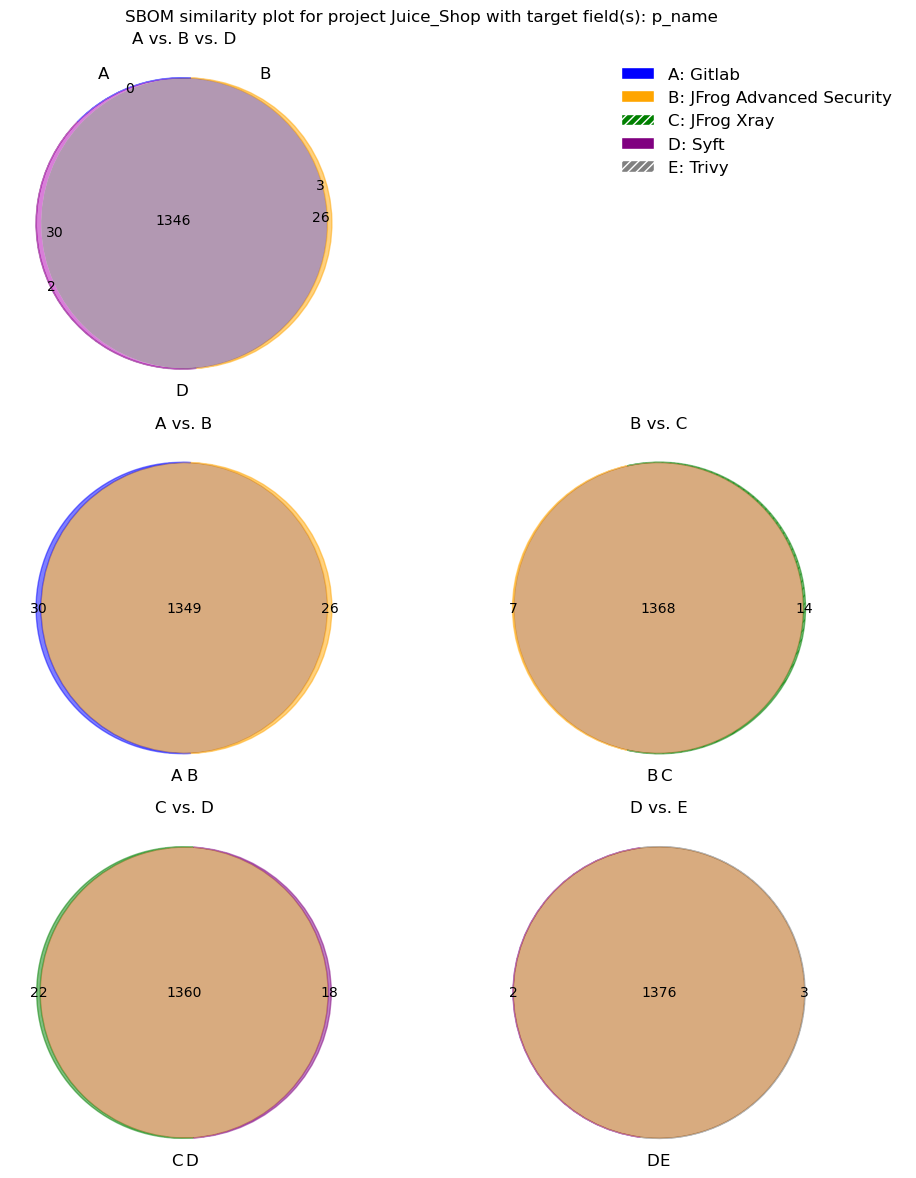

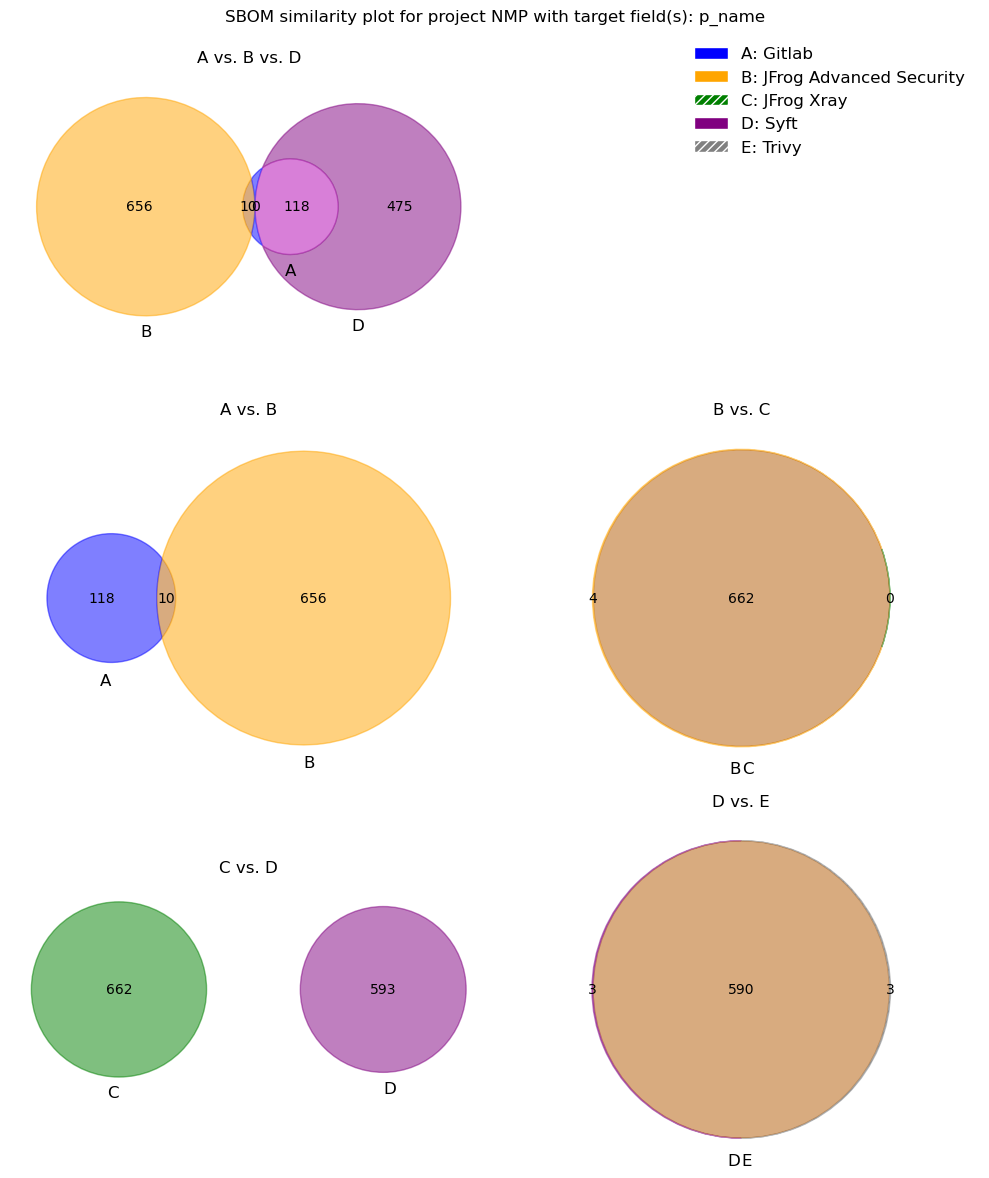

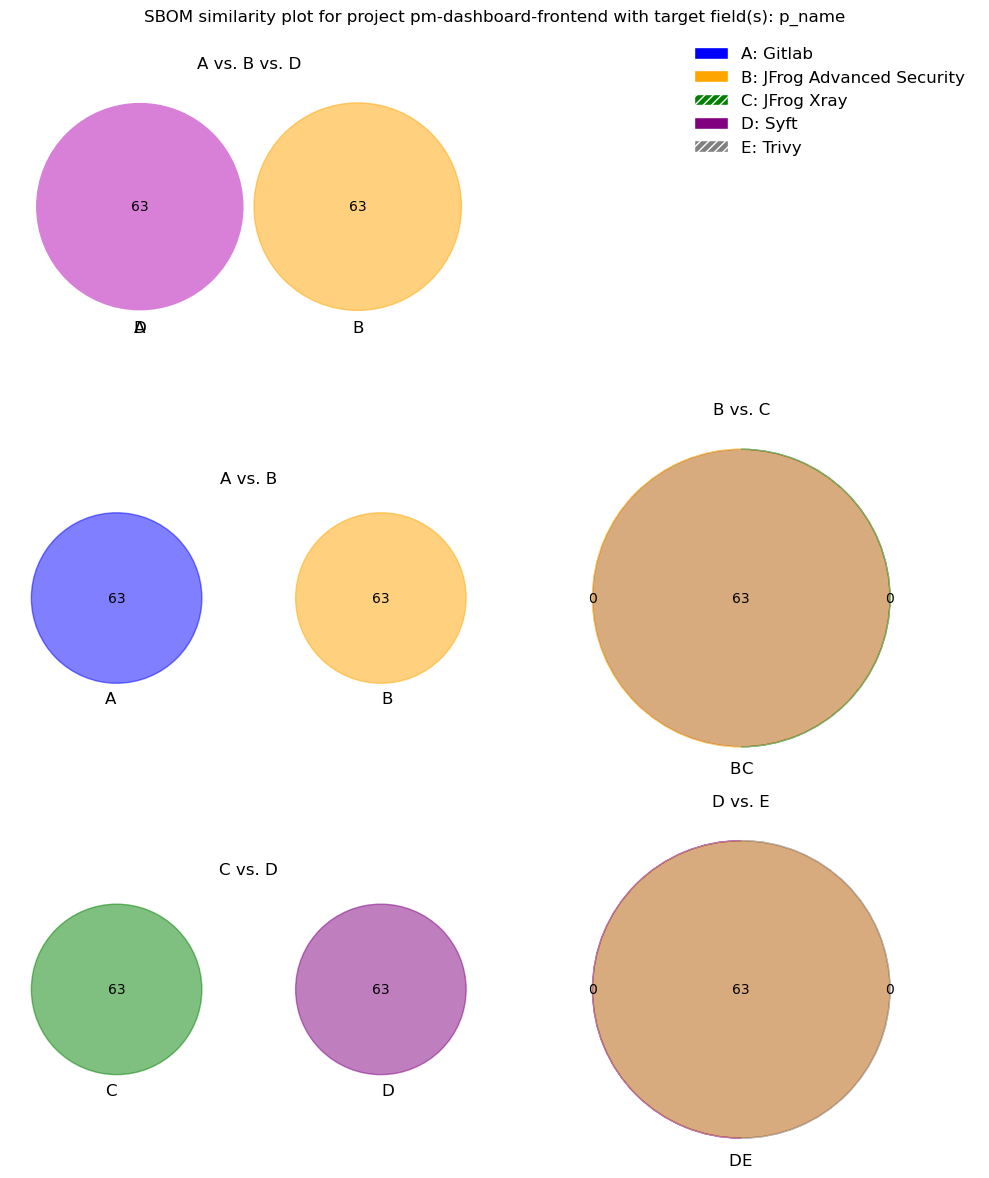

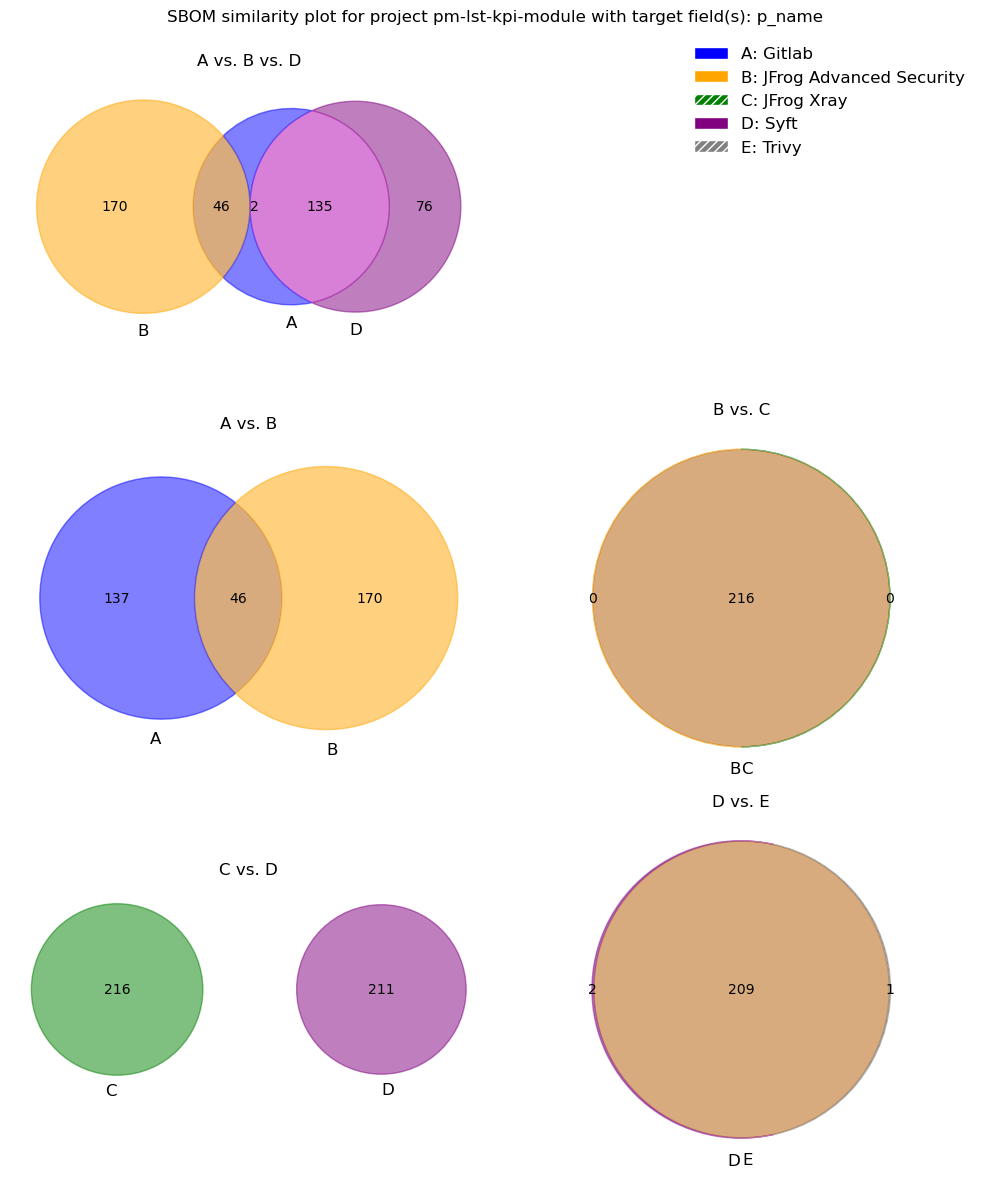

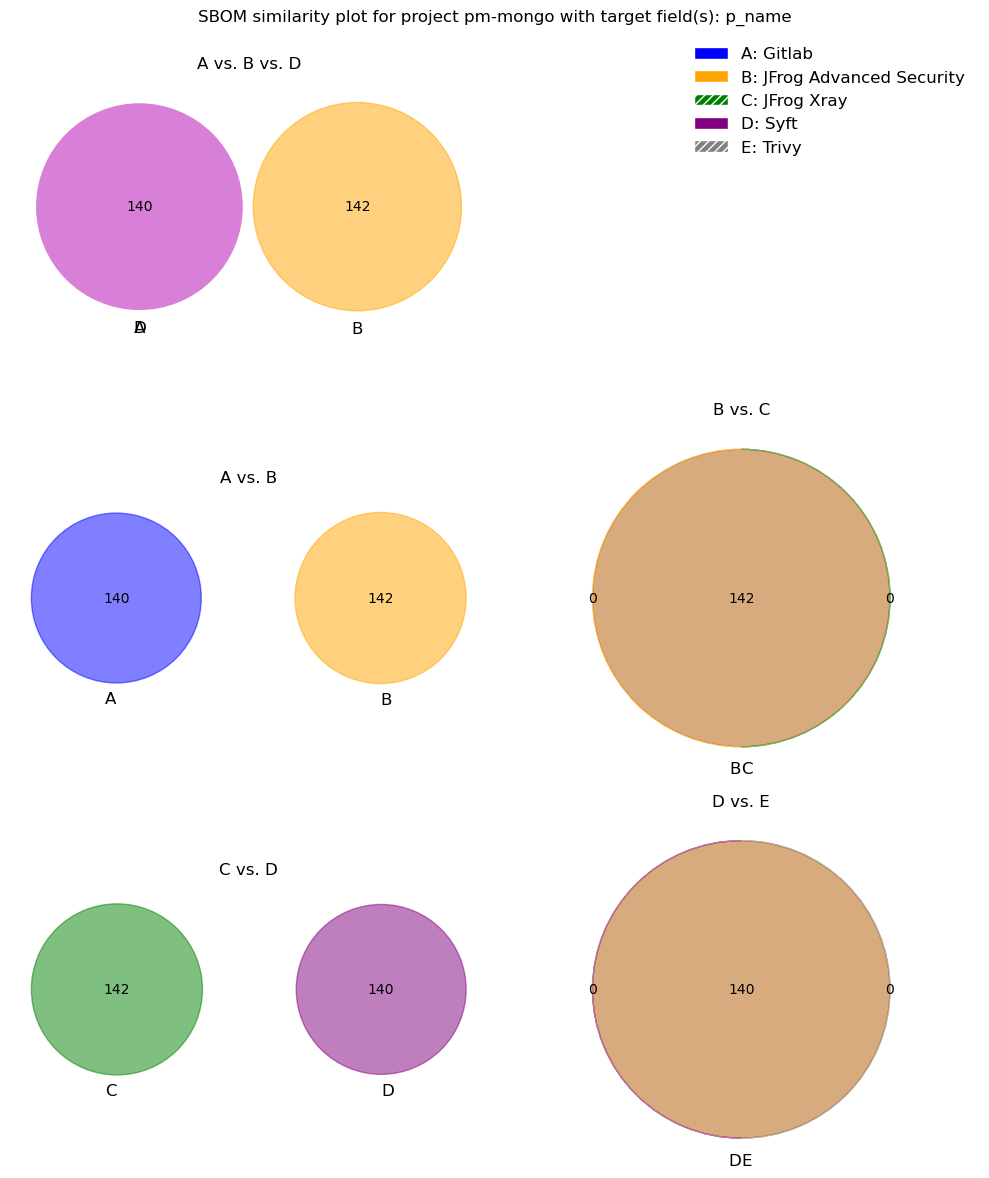

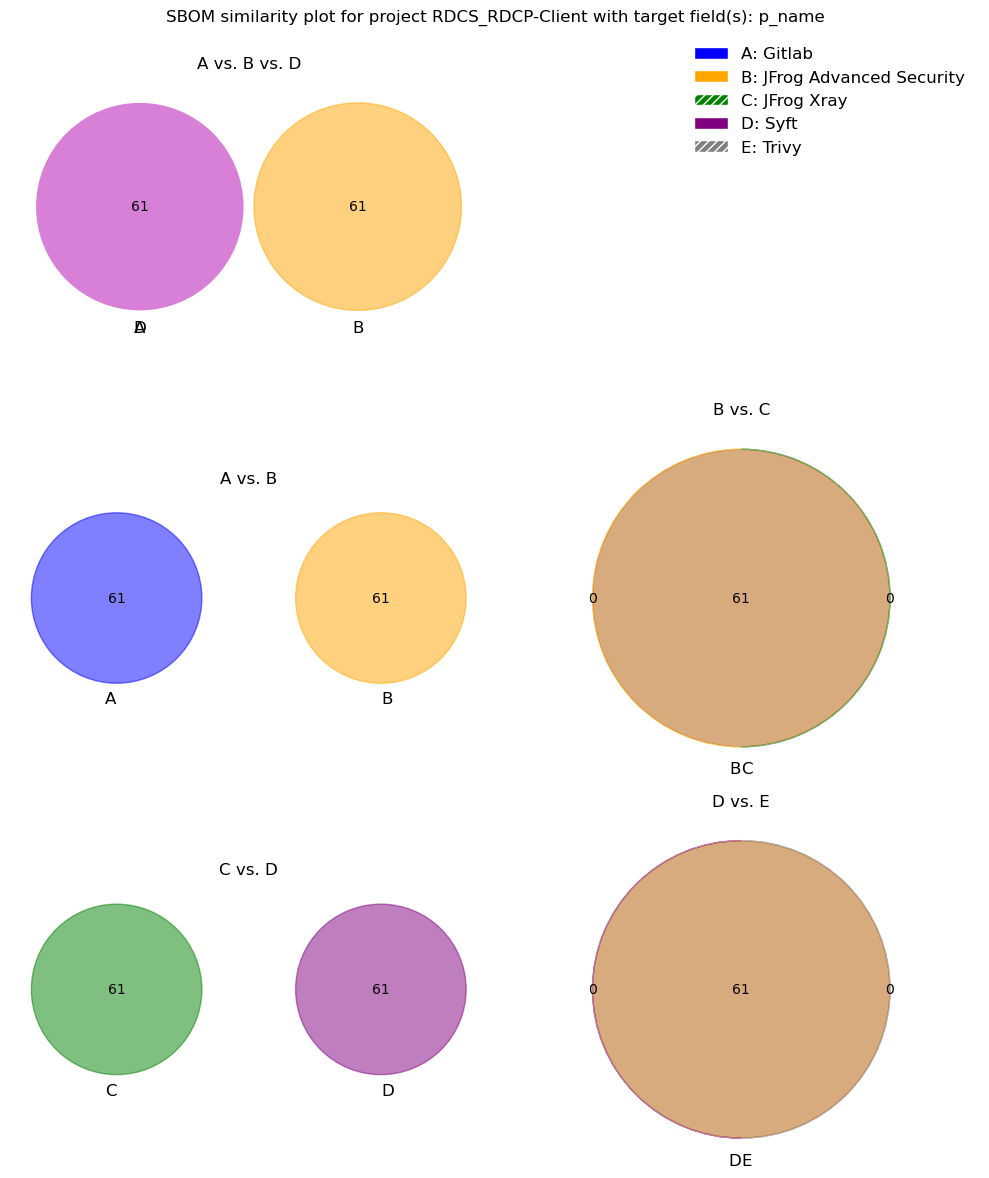

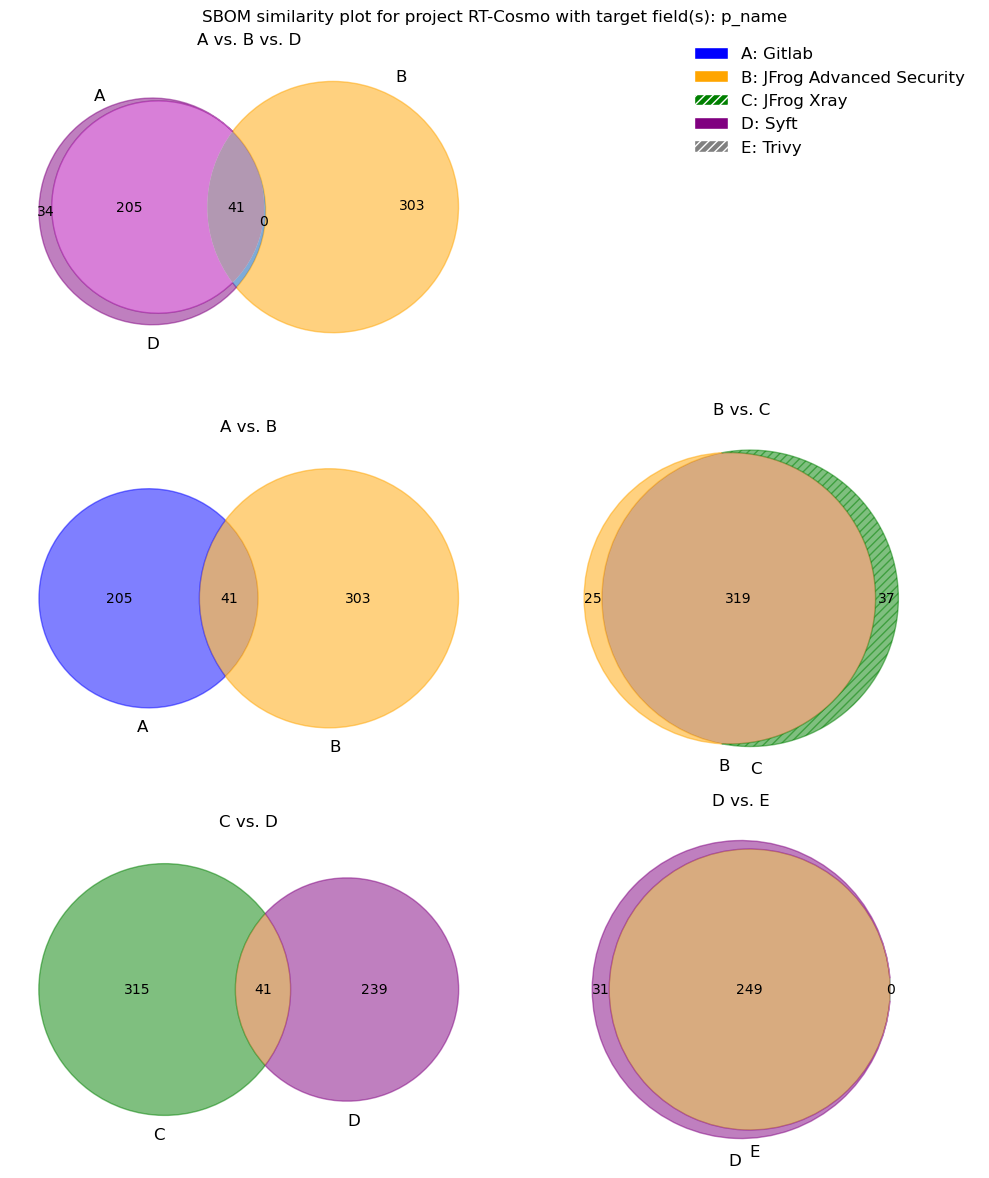

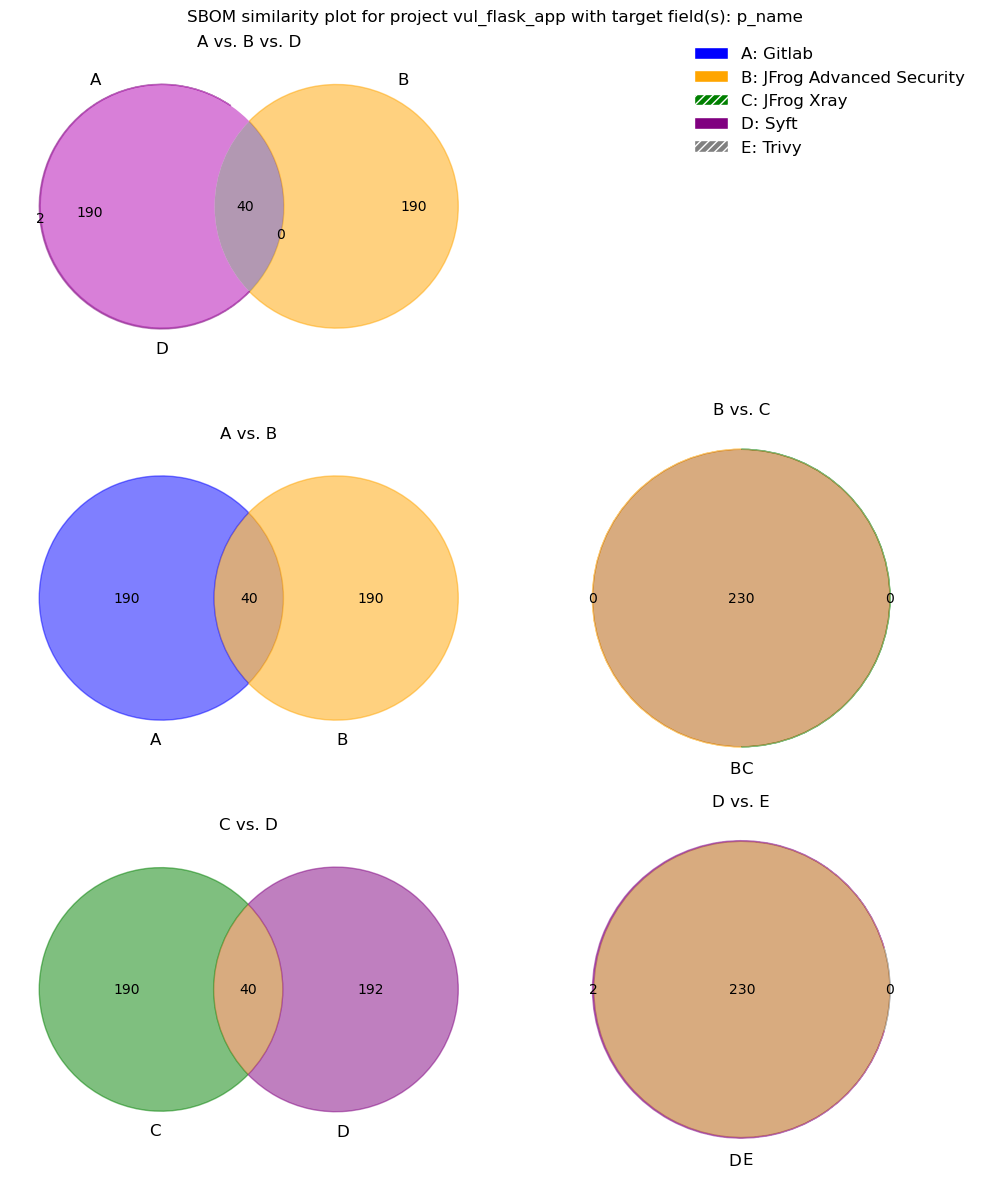

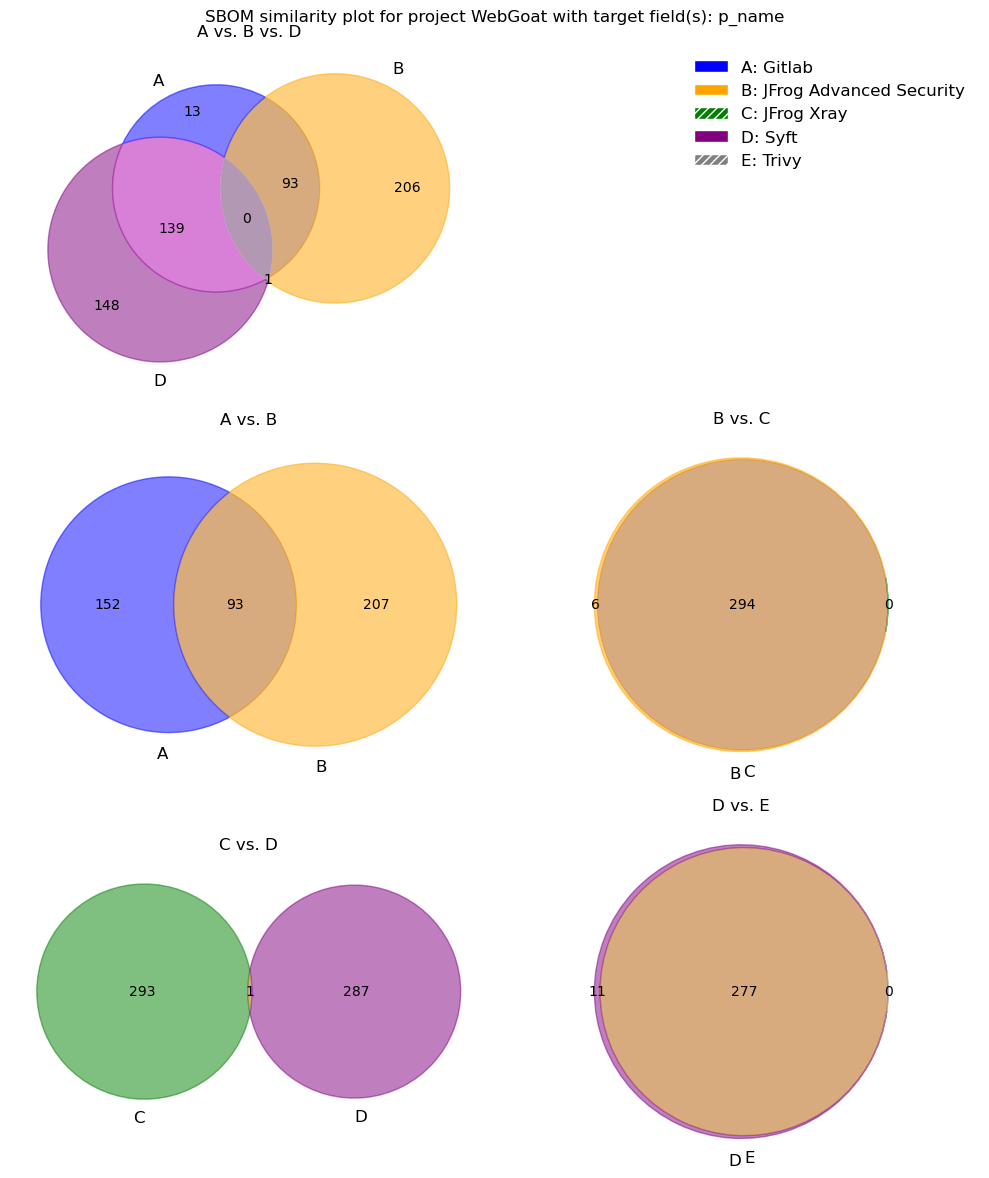

In [243]:
# define project name and target field 
project_name = in_scope[0]
target_fields = 'p_name'

for project_name in in_scope:
    # get project data in data frame
    project_scanner_data = collect_all_scanner_data_of_project(project_name)

    # visualize project scanner data
    target_output_file = f"SBOM_comparison_{project_name}_{target_fields}"
    create_SBOM_similarity_plot(project_name, target_fields, project_scanner_data, target_output_file)

# Workarea

## Analyse purl

In [34]:
from packageurl import PackageURL

In [41]:
test_purls = [
    'pkg:bitbucket/birkenfeld/pygments-main@244fd47e07d1014f0aed9c',
    'pkg:deb/debian/curl@7.50.3-1?arch=i386&distro=jessie',
    'pkg:docker/cassandra@sha256:244fd47e07d1004f0aed9c',
    'pkg:docker/customer/dockerimage@sha256:244fd47e07d1004f0aed9c?repository_url=gcr.io',
    'pkg:gem/jruby-launcher@1.1.2?platform=java',
    'pkg:gem/ruby-advisory-db-check@0.12.4',
    'pkg:github/package-url/purl-spec@244fd47e07d1004f0aed9c',
    'pkg:golang/google.golang.org/genproto#googleapis/api/annotations',
    'pkg:maven/org.apache.xmlgraphics/batik-anim@1.9.1?packaging=sources',
    'pkg:maven/org.apache.xmlgraphics/batik-anim@1.9.1?repository_url=repo.spring.io%2Frelease',
    'pkg:npm/%40angular/animation@12.3.1',
    'pkg:npm/foobar@12.3.1',
    'pkg:nuget/EnterpriseLibrary.Common@6.0.1304',
    'pkg:pypi/django@1.11.1',
    'pkg:rpm/fedora/curl@7.50.3-1.fc25?arch=i386&distro=fedora-25',
    'pkg:rpm/opensuse/curl@7.56.1-1.1.?arch=i386&distro=opensuse-tumbleweed',
    'fakestring'
]

for test_purl in test_purls:
    try:
        purl = PackageURL.from_string(test_purl)
        print(purl.to_dict())
        purl_dict = purl.to_dict()
    except Exception as e:
        print(f"Error processing PackageURL: {e}")
    

{'type': 'bitbucket', 'namespace': 'birkenfeld', 'name': 'pygments-main', 'version': '244fd47e07d1014f0aed9c', 'qualifiers': None, 'subpath': None}
{'type': 'deb', 'namespace': 'debian', 'name': 'curl', 'version': '7.50.3-1', 'qualifiers': {'arch': 'i386', 'distro': 'jessie'}, 'subpath': None}
{'type': 'docker', 'namespace': None, 'name': 'cassandra', 'version': 'sha256:244fd47e07d1004f0aed9c', 'qualifiers': None, 'subpath': None}
{'type': 'docker', 'namespace': 'customer', 'name': 'dockerimage', 'version': 'sha256:244fd47e07d1004f0aed9c', 'qualifiers': {'repository_url': 'gcr.io'}, 'subpath': None}
{'type': 'gem', 'namespace': None, 'name': 'jruby-launcher', 'version': '1.1.2', 'qualifiers': {'platform': 'java'}, 'subpath': None}
{'type': 'gem', 'namespace': None, 'name': 'ruby-advisory-db-check', 'version': '0.12.4', 'qualifiers': None, 'subpath': None}
{'type': 'github', 'namespace': 'package-url', 'name': 'purl-spec', 'version': '244fd47e07d1004f0aed9c', 'qualifiers': None, 'subpat

In [39]:
purl.to_dict().keys()

dict_keys(['type', 'namespace', 'name', 'version', 'qualifiers', 'subpath'])

In [37]:
purl.to_dict()

{'type': 'maven',
 'namespace': 'org.apache.commons',
 'name': 'io',
 'version': '1.3.4',
 'qualifiers': None,
 'subpath': None}

## Visualize the results

In [14]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

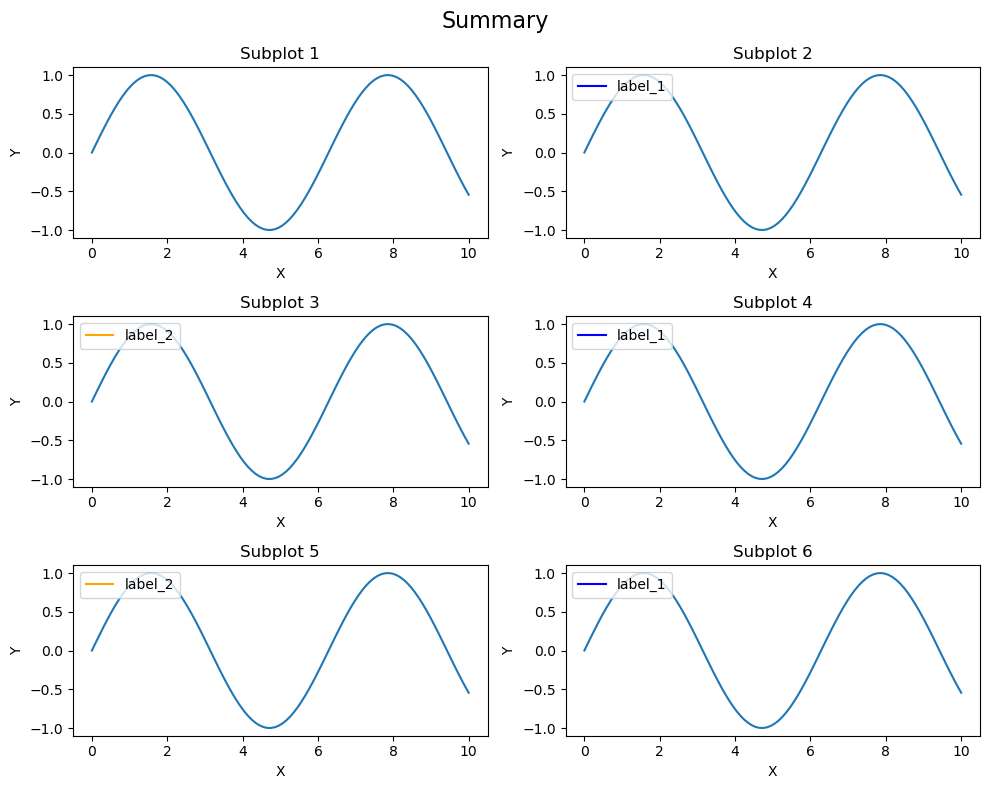

In [30]:

# Create a figure with 3x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 8))

# Plot data on each subplot
for i, ax in enumerate(axs.flat):
    ax.plot(x, y, label=f'Subplot {i+1}')
    ax.set_title(f'Subplot {i+1}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    # Add legends only for the other five subplots
    if i != 0:
        ax.legend(loc='upper left', handles=[
            plt.Line2D([0], [0], color='blue' if i % 2 == 1 else 'orange', label='label_1' if i % 2 == 1 else 'label_2')
        ])

# Set a title for the entire subplot grid
fig.suptitle("Summary", fontsize=16)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


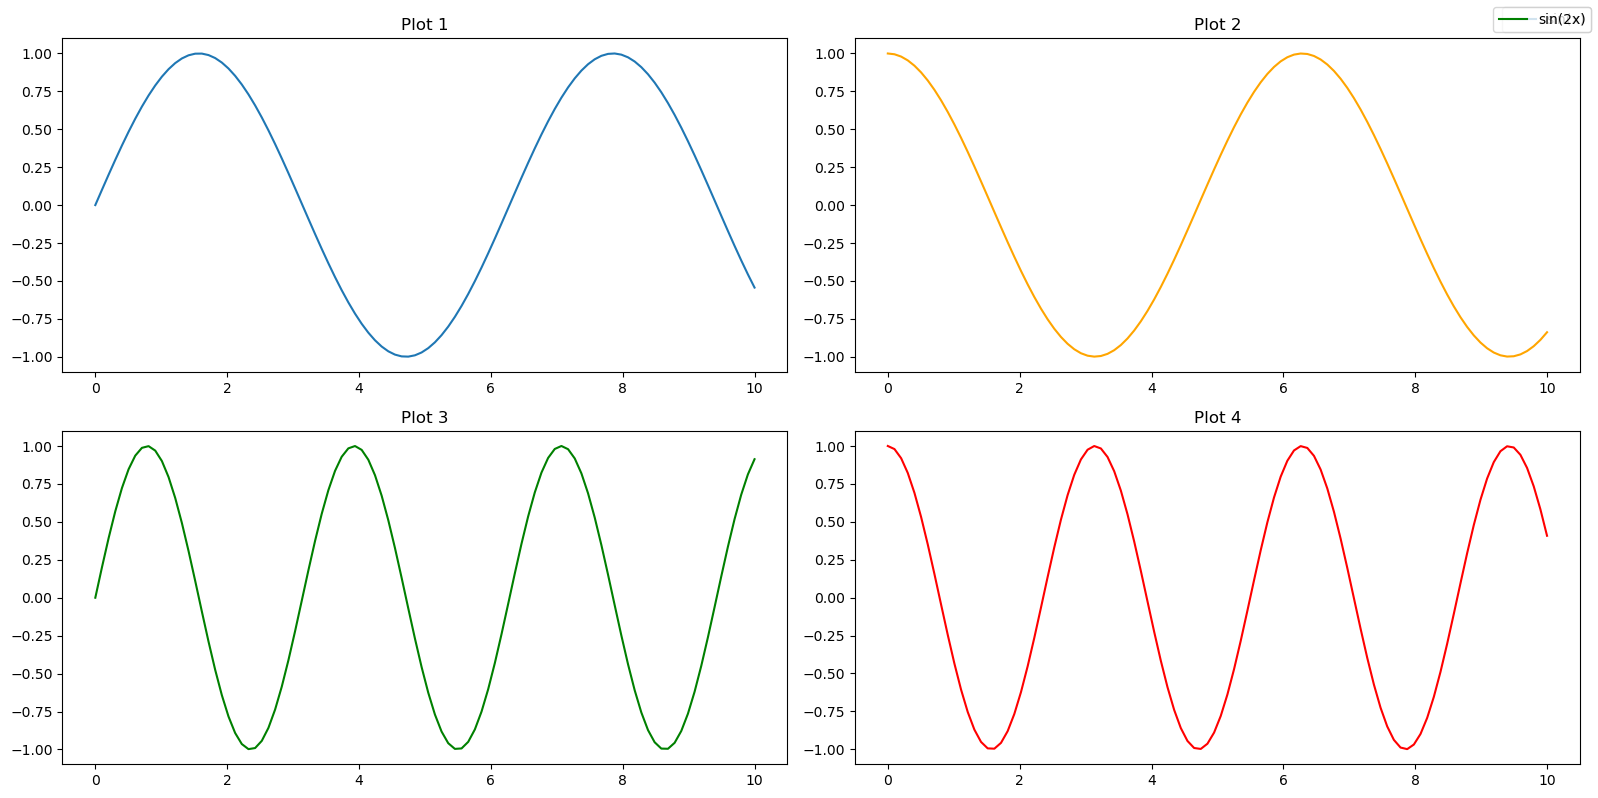

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Create some sample data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.sin(2*x)
y4 = np.cos(2*x)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Plot data on each subplot
axs[0, 0].plot(x, y1, label='sin(x)')
axs[0, 1].plot(x, y2, label='cos(x)', color='orange')
axs[1, 0].plot(x, y3, label='sin(2x)', color='green')
axs[1, 1].plot(x, y4, label='cos(2x)', color='red')

# Add a legend to the entire figure
lines, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')
lines, labels = fig.axes[2].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right')

# Add titles to subplots
axs[0, 0].set_title('Plot 1')
axs[0, 1].set_title('Plot 2')
axs[1, 0].set_title('Plot 3')
axs[1, 1].set_title('Plot 4')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


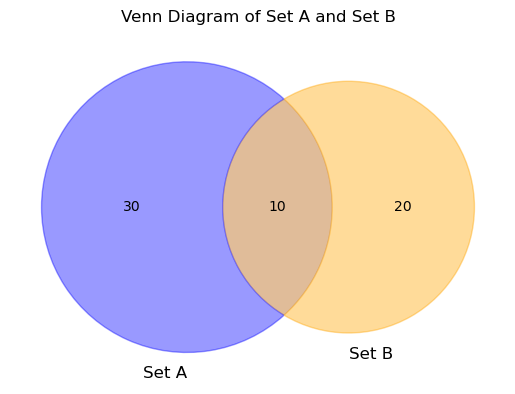

In [39]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Create the Venn diagram
venn = venn2(subsets=(30, 20, 10), set_labels=('Set A', 'Set B'))

# Customize colors
venn.get_patch_by_id('10').set_color('blue')
venn.get_patch_by_id('01').set_color('orange')

# Set the title
plt.title('Venn Diagram of Set A and Set B')

# Show the plot
plt.show()

In [28]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Define your sets
A = {"apple", "banana", "cherry", "date"}
B = {"banana", "cherry", "date", "elderberry"}
#C = {"cherry", "date", "elderberry", "fig"}
#D = {"date", "elderberry", "fig", "grape"}
#E = {"elderberry", "fig", "grape", "honeydew"}

#all_sets = [A, B, C, D, E]
all_sets = [A, B]
#set_names = ["A", "B"]

# Generate all possible combinations of sets
all_combinations = []
for r in range(2, len(all_sets) + 1):
    all_combinations.extend(itertools.combinations(all_sets, r))

# Initialize counts for different combinations
counts = {}
for combination in all_combinations:
    combined_set = set.intersection(*combination)
    set_indices = [set_names.index(s) for s in combination]
    counts[tuple(set_indices)] = len(combined_set)

# Visualize the results
x_labels = [" ".join([set_names[i] for i in indices]) for indices in counts.keys()]
y_values = list(counts.values())

plt.figure(figsize=(10, 6))
sns.barplot(x=x_labels, y=y_values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Set Combinations")
plt.ylabel("Number of Elements")
plt.title("Elements in Different Set Combinations")
plt.tight_layout()
plt.show()

ValueError: {'cherry', 'banana', 'date', 'apple'} is not in list

In [33]:
A = [1, 2, 3]
B = [2, 3, 4, 5]
combinations = list(itertools.product(A, B))
print(combinations)

[(1, 2), (1, 3), (1, 4), (1, 5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 2), (3, 3), (3, 4), (3, 5)]
